In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\Chris\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\Chris\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
Importing plotly failed. Interactive plots will not work.


# Load the Data/Filtering for Chosen Zipcodes and Data Preprocessing

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

I decided to take a look at the best place to invest in the city of Los Angeles so I'll make a new dataframe only containing data from Los Angeles.

In [3]:
los_angeles = df[df['City'] == 'Los Angeles']

In [4]:
los_angeles.head()

RegionID  RegionName         City State                           Metro  \
30      96027       90046  Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
75      96015       90034  Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
86      96025       90044  Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
107     96007       90026  Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
133     96047       90066  Los Angeles    CA  Los Angeles-Long Beach-Anaheim   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
30   Los Angeles        31  340600.0  341700.0  343000.0  ...  1839800   
75   Los Angeles        76  231300.0  231700.0  232100.0  ...  1287500   
86   Los Angeles        87  119500.0  119500.0  119400.0  ...   383800   
107  Los Angeles       108  138100.0  138300.0  138300.0  ...   883600   
133  Los Angeles       134  241100.0  241000.0  240900.0  ...  1435000   

     2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
30   1861100  1888600  1903900  1907500  1922100  1952400  1974500  1975900   
75   1310000  1329900  1347200  1360300  1368500  1382700  1398000  1411400   
86    386900   390600   394300   398600   404200   409700   414300   418500   
107   895800   907700   919900   932600   947300   962600   973700   975200   
133  1454100  1471100  1473300  1470400  1476200  1490500  1496300  1494000   

     2018-04  
30   1966900  
75   1419100  
86    421100  
107   972100  
133  1489900  

[5 rows x 272 columns]

In [5]:
## check to see how many unique zipcodes there are

los_angeles['RegionName'].nunique()

95

In [6]:
## changing dataframe to long format so it is easier to work with for time series modeling

LA = pd.melt(los_angeles, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='time')
LA['time'] = pd.to_datetime(LA['time'], infer_datetime_format=True)
LA = LA.dropna(subset=['value'])

In [7]:
LA['RegionName'].unique()

array([90046, 90034, 90044, 90026, 90066, 90019, 90004, 91342, 90011,
       90025, 90027, 91335, 90731, 90036, 91331, 90042, 90006, 90024,
       90028, 91402, 91367, 90049, 91406, 90020, 91405, 91601, 90047,
       90018, 90003, 91343, 90045, 90016, 90043, 91304, 90037, 90005,
       91344, 90057, 91605, 90029, 90291, 91606, 91423, 90065, 90292,
       90008, 91401, 91604, 90744, 91306, 90035, 91607, 90048, 91311,
       90007, 90068, 90032, 90012, 90033, 90038, 90064, 91326, 91316,
       90039, 90002, 91325, 91403, 90017, 91352, 91356, 90031, 90023,
       91364, 90041, 90059, 90015, 91042, 91602, 90272, 91324, 91303,
       90062, 91411, 90710, 90732, 91307, 91040, 90061, 90293, 91436,
       91345, 90077, 90248, 90013, 90014], dtype=int64)

In [8]:
## getting rid of unnecessary columns

LA = LA.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
LA.head()

RegionName       time     value
0       90046 1996-04-01  340600.0
1       90034 1996-04-01  231300.0
2       90044 1996-04-01  119500.0
3       90026 1996-04-01  138100.0
4       90066 1996-04-01  241100.0

In [9]:
## checking to see if there are any zipcodes with missing values

LA['RegionName'].value_counts()[-7:]

90049    265
90065    265
91303    265
91335    265
90732    265
90013     58
90014     58
Name: RegionName, dtype: int64

In [10]:
## removing zipcodes that have missing values

LA = LA[~LA['RegionName'].isin([90013, 90014])]

In [11]:
## checking to see if the zipcodes got removed properly

LA['RegionName'].value_counts()[-5:]

90065    265
91303    265
91335    265
91367    265
90732    265
Name: RegionName, dtype: int64

# EDA and Visualization

Now that we have our data, lets take a quick look at the values of homes in Los Angeles for each zipcode.

In [12]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


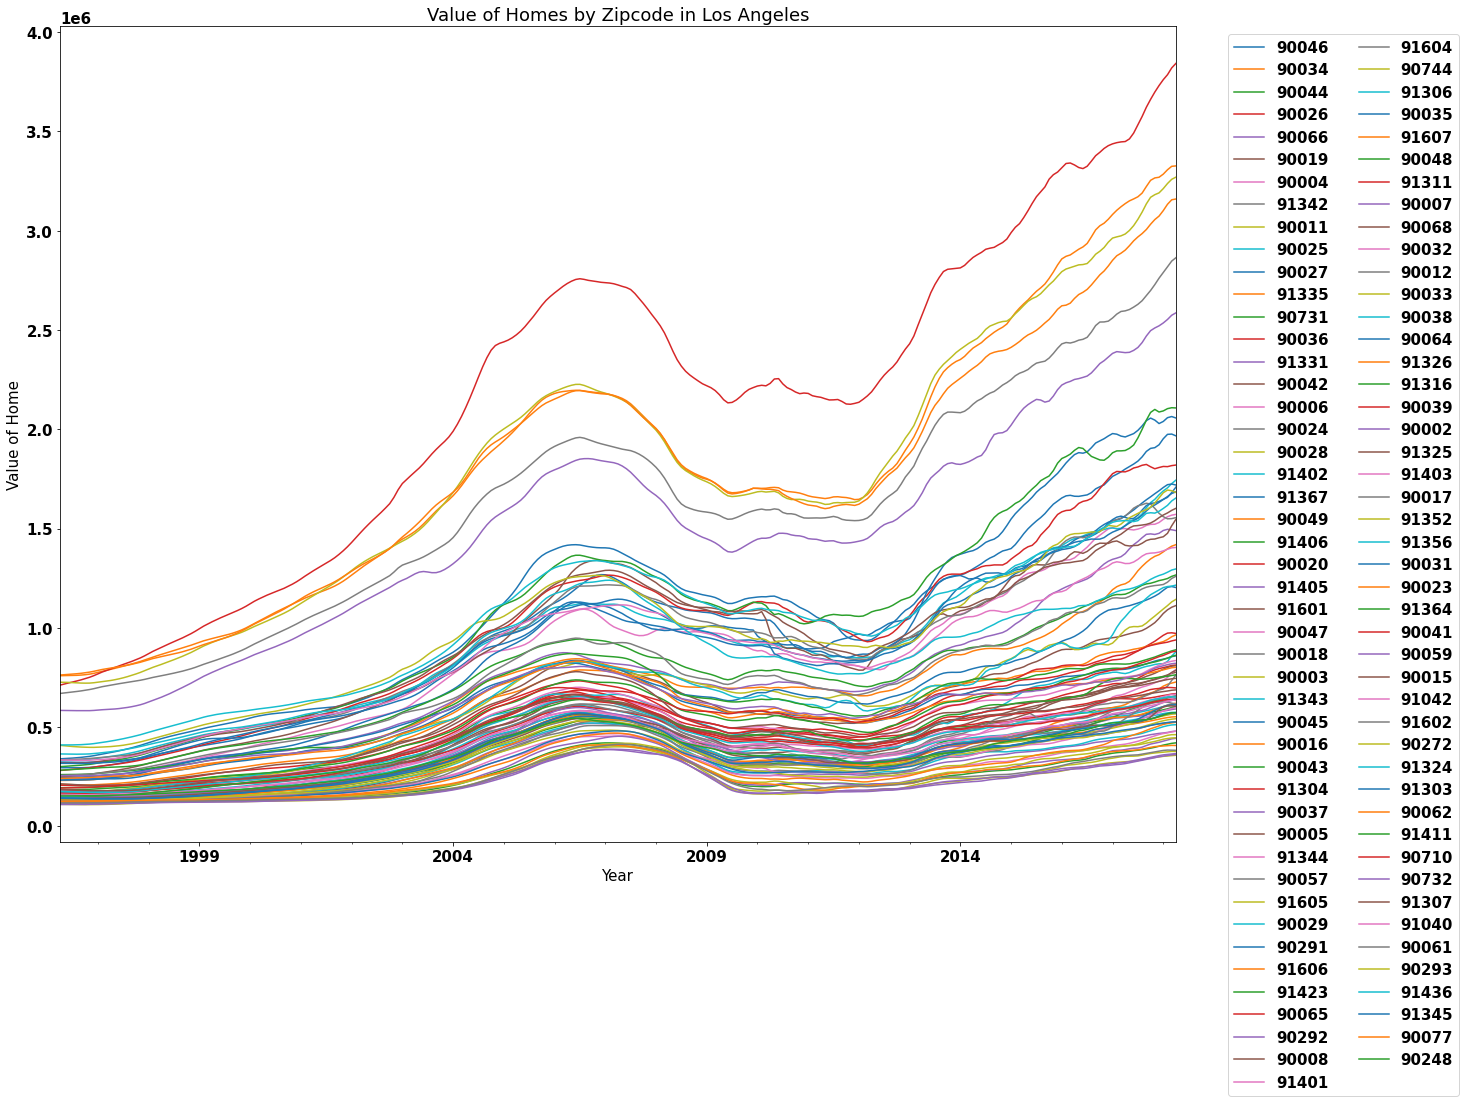

In [13]:
for zipcode in LA['RegionName'].unique():
    temp_df = LA[LA['RegionName'] == zipcode].drop('RegionName', axis=1).set_index('time')
    temp_df['value'].plot(figsize=(20, 15), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.ylabel('Value of Home')
plt.xlabel('Year')
plt.title('Value of Homes by Zipcode in Los Angeles')
plt.show()

Taking a quick glance at the data, you can clearly see the effects of the housing crash in 2008 affecting housing prices throughout Los Angeles. It looks like the zipcodes with the highest home values were able to recover their losses by 2013-2014 and have reached new highs. However, the zipcodes with the lowest home values have yet to recover to their pre-2008 values. Since we are looking for the zipcodes with the highest return on investment, I'll be taking a look at the best zipcodes to invest in from the top 20 zipcodes in Los Angeles.

In [14]:
## making a new dataframe with just the values from the top 20 zipcodes in Los Angeles

top_20 = los_angeles.nlargest(20, '2018-04')
top_20 = top_20 = pd.melt(top_20, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='time')
top_20['time'] = pd.to_datetime(top_20['time'], infer_datetime_format=True)
top_20 = top_20.dropna(subset=['value'])
top_20 = top_20.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
top_20.head()

RegionName       time     value
0       90020 1996-04-01  711600.0
1       90049 1996-04-01  759100.0
2       90272 1996-04-01  726400.0
3       90077 1996-04-01  762500.0
4       90024 1996-04-01  669700.0

In [15]:
top_20['RegionName'].unique()

array([90020, 90049, 90272, 90077, 90024, 90292, 90048, 90291, 90046,
       90036, 90025, 90027, 90035, 90064, 90293, 91436, 90068, 90004,
       91604, 90005], dtype=int64)

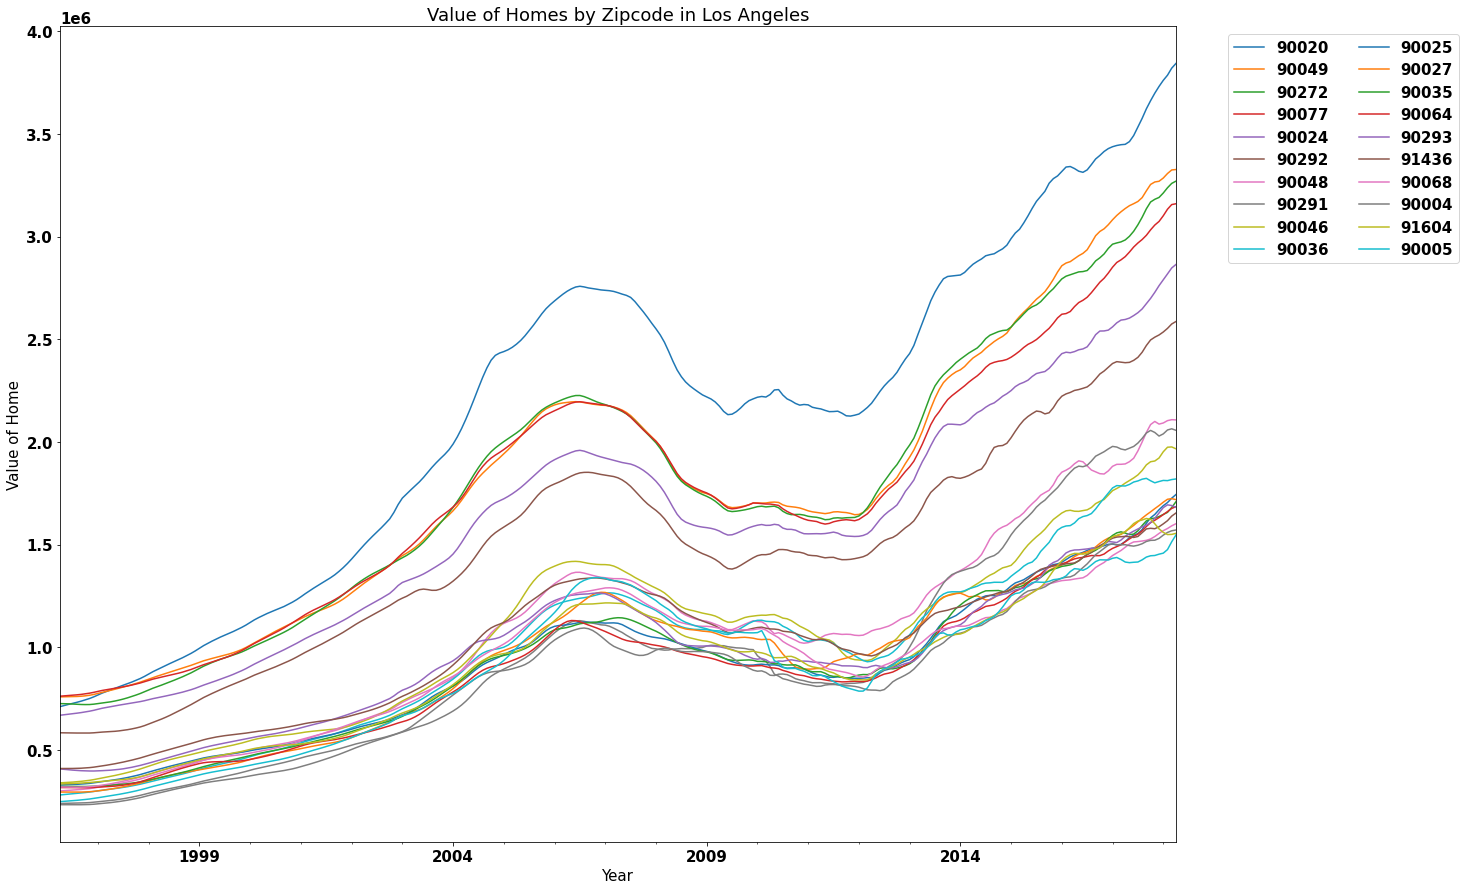

In [16]:
## graphing the value of homes in top 20 zipcodes

for zipcode in top_20['RegionName'].unique():
    temp_df = top_20[top_20['RegionName'] == zipcode].drop('RegionName', axis=1).set_index('time')
    temp_df['value'].plot(figsize=(20, 15), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.ylabel('Value of Home')
plt.xlabel('Year')
plt.title('Value of Homes by Zipcode in Los Angeles')
plt.show()

We want to make decision based on post housing crash trends so we'll only be taking a look at data from 2010 onward.

In [17]:
## separate data to only include dates after 2010

LA = top_20[top_20['time'] > '2009-12']
LA.head()

RegionName       time      value
3300       90020 2010-01-01  2217900.0
3301       90049 2010-01-01  1703200.0
3302       90272 2010-01-01  1685200.0
3303       90077 2010-01-01  1702000.0
3304       90024 2010-01-01  1594900.0

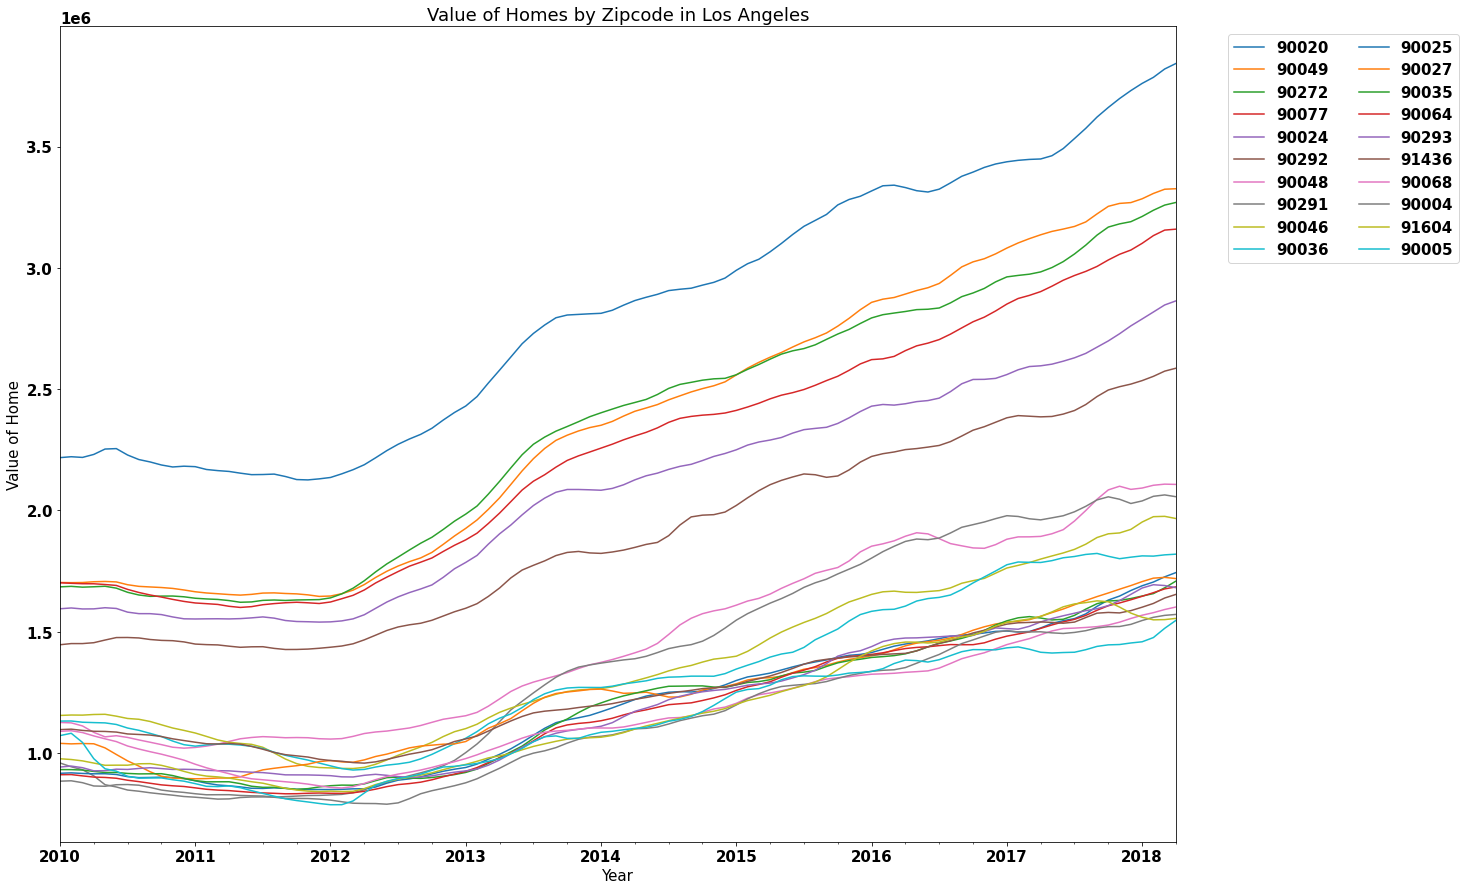

In [18]:
for zipcode in LA['RegionName'].unique():
    temp_df = LA[LA['RegionName'] == zipcode].drop('RegionName', axis=1).set_index('time')
    temp_df['value'].plot(figsize=(20, 15), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.ylabel('Value of Home')
plt.xlabel('Year')
plt.title('Value of Homes by Zipcode in Los Angeles')
plt.show()

# Removing Trends

I'll be going through 2 zipcodes to see which method works best to make the data stationary. The zipcodes I'll be using are 90272 and 90025. When looking at the graph above, the zipcodes seem to be split between the top 6 zipcodes by values and the rest of the zipcodes. 90272 is part of the top 6 zipcodes by value while 90025 is part of the bottom 14 zipcodes.

In [19]:
## function to check for stationarity
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS['value']) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

Text(0, 0.5, 'Value in Dollars')

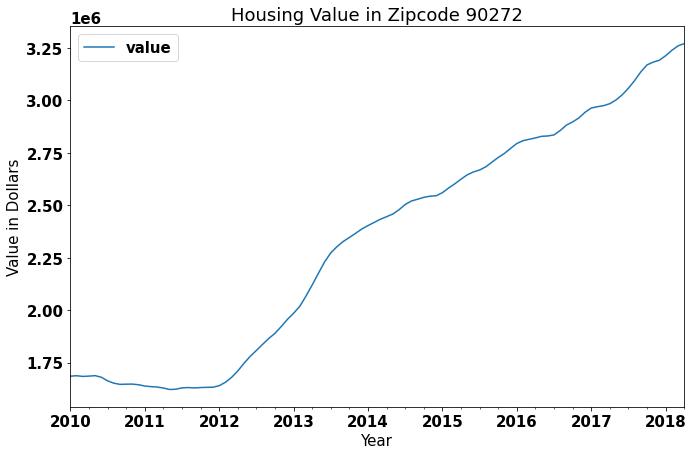

In [20]:
## splitting data into specific zipcodes

zip_90272 = LA[LA['RegionName'] == 90272].drop('RegionName', axis=1).set_index('time')
zip_90272.plot(figsize=(11, 7));
plt.title('Housing Value in Zipcode 90272')
plt.xlabel('Year')
plt.ylabel('Value in Dollars')

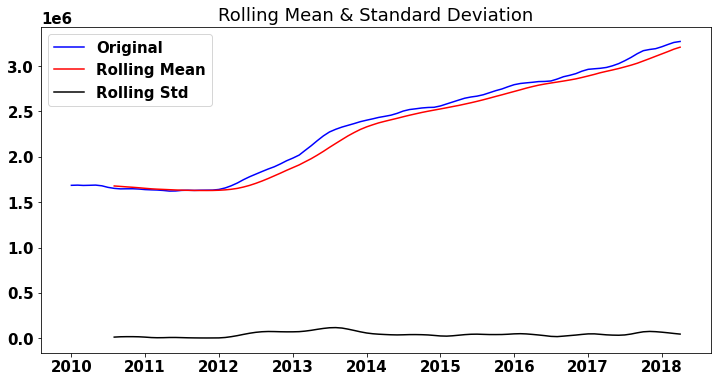

Results of Dickey-Fuller Test: 

Test Statistic                 -0.667612
p-value                         0.854961
#Lags Used                      9.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


In [21]:
stationarity_check(zip_90272)

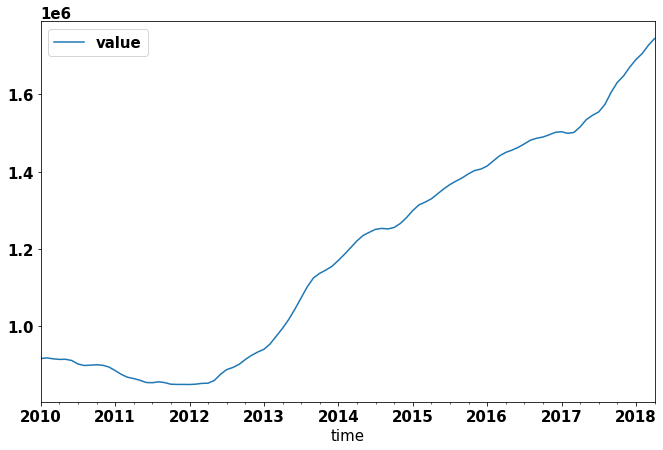

In [22]:
zip_90025 = LA[LA['RegionName'] == 90025].drop('RegionName', axis=1).set_index('time')
zip_90025.plot(figsize=(11,7));

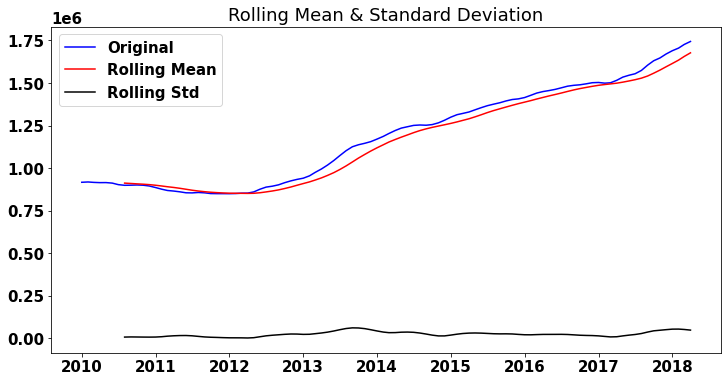

Results of Dickey-Fuller Test: 

Test Statistic                  0.134241
p-value                         0.968323
#Lags Used                      8.000000
Number of Observations Used    91.000000
Critical Value (1%)            -3.504343
Critical Value (5%)            -2.893866
Critical Value (10%)           -2.584015
dtype: float64


In [23]:
stationarity_check(zip_90025)

Just by taking a look at our two graphs, we can see there is a clear upward linear trend. The Dickey-Fuller test has a null hypothesis that the data is not stationary. With a p-value much greater than 0.05 for both datasets, we fail to reject the null hypothesis and conclude that our data is not stationary.

## Differencing

I'll be taking a look to see if our data will become stationary through differencing so that it can be used in ARIMA modeling.

In [24]:
diff_90272 = np.log(zip_90272).diff(periods=4)
diff_90272.dropna(inplace=True)

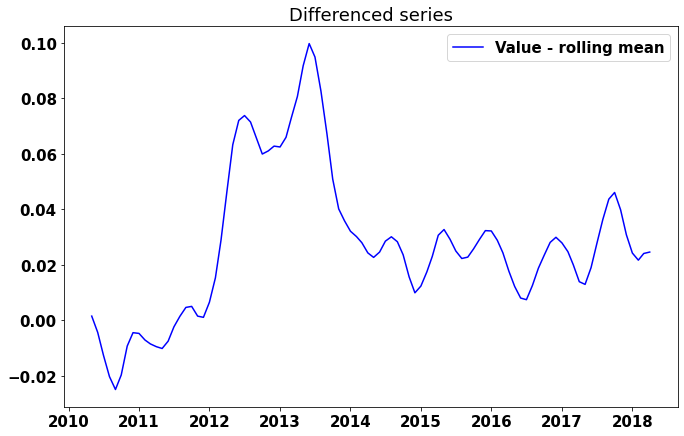

In [25]:
fig = plt.figure(figsize=(11,7))
plt.plot(diff_90272, color='blue',label='Value - rolling mean')
plt.legend(loc='best')
plt.title('Differenced series')
plt.show(block=False)

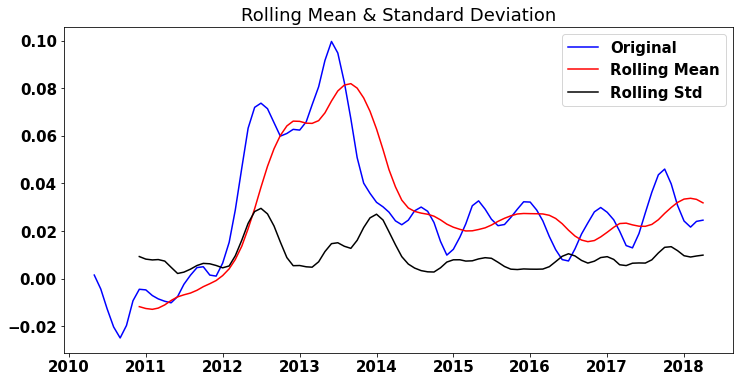

Results of Dickey-Fuller Test: 

Test Statistic                 -3.423992
p-value                         0.010168
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [26]:
stationarity_check(diff_90272)

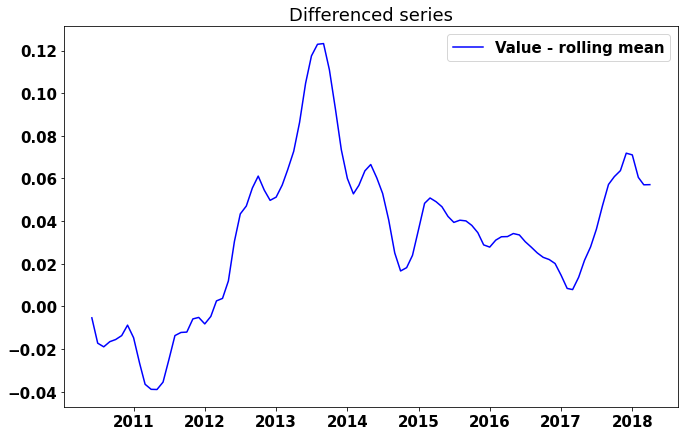

In [27]:
diff_90025 = np.log(zip_90025).diff(periods=5)
diff_90025.dropna(inplace=True)

fig = plt.figure(figsize=(11,7))
plt.plot(diff_90025, color='blue',label='Value - rolling mean')
plt.legend(loc='best')
plt.title('Differenced series')
plt.show(block=False)

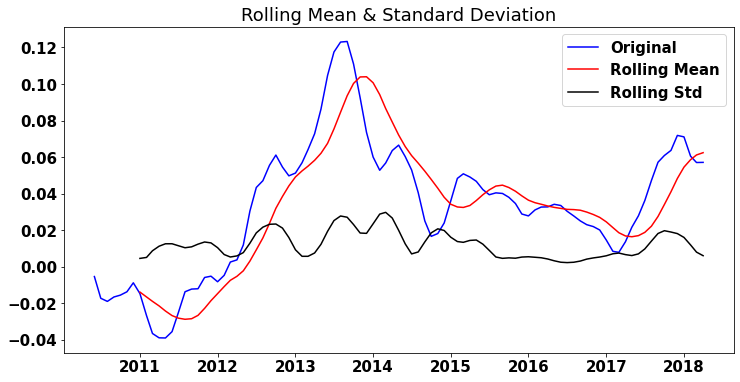

Results of Dickey-Fuller Test: 

Test Statistic                 -2.932425
p-value                         0.041705
#Lags Used                     11.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [28]:
stationarity_check(diff_90025)

I had to take the log transformation for zipcode 90025 to be able to make the data stationary using differencing. Because of this I will be using log transformed data before running it through the ARIMA model.

With p values lower than 0.05 for both zipcodes, we can reject the null hypothesis and conclude that our data is stationary.

## Decomposition

In [29]:
## define a function to decompose data to see trends, seasonality, and residuals

def decomposition(df):
    sd = seasonal_decompose(df)

    # Gather the trend, seasonality, and residuals 
    trend = sd.trend
    seasonal = sd.seasonal
    residual = sd.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()
    
    return residual.dropna()

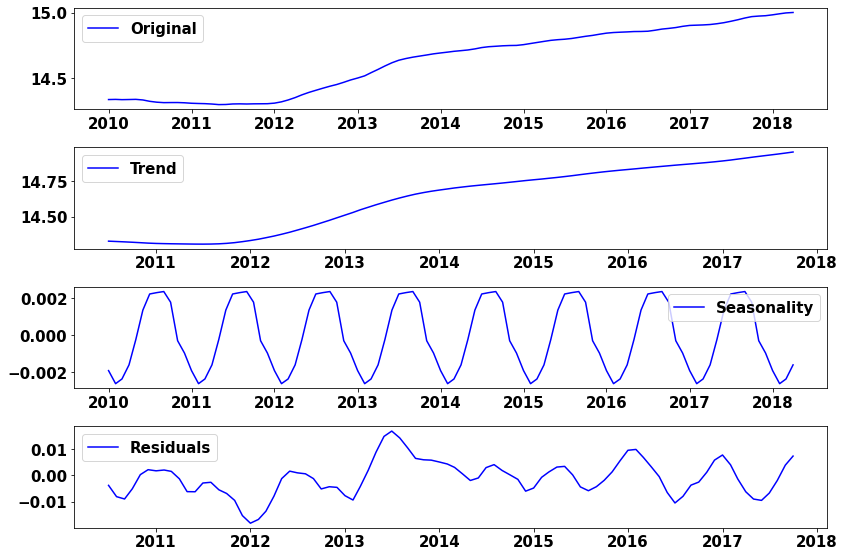

In [30]:
sd_90272 = decomposition(np.log(zip_90272))

Looks like there is an upward trend that stabilizes between 2014 and 2015. It looks like there is seasonality in the data looking at the seasonality graph but with the range of values being so low we can assume that there is no seasonality in our data. A quick glance at the graph of our original data confirms this because there does not seem to be any seasonality in the graph of our original data before decomposition.

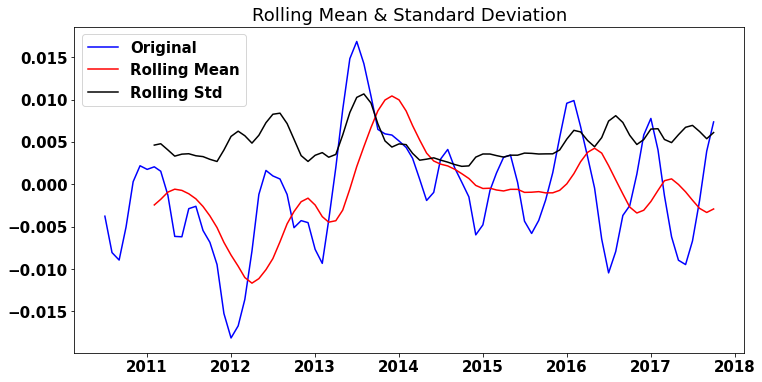

Results of Dickey-Fuller Test: 

Test Statistic                 -2.382952
p-value                         0.146606
#Lags Used                      6.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


In [31]:
# Check stationarity
stationarity_check(sd_90272)

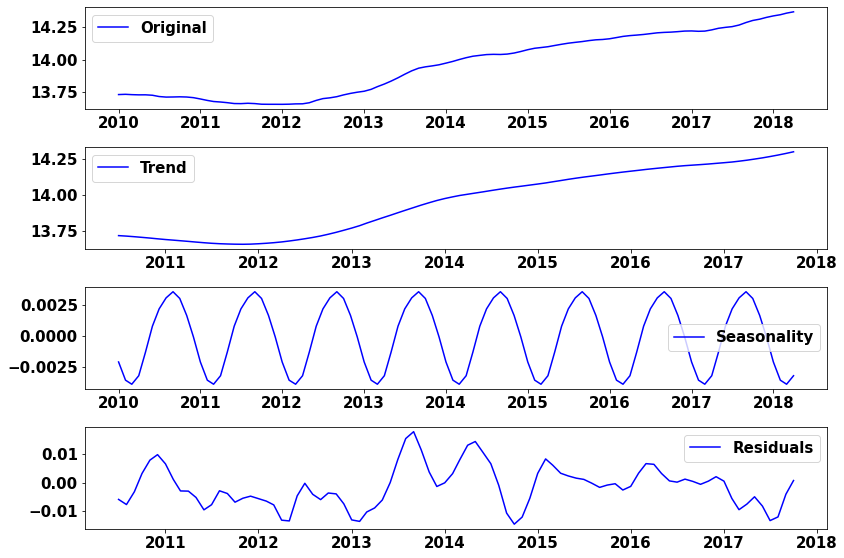

In [32]:
sd_90025 = decomposition(np.log(zip_90025))

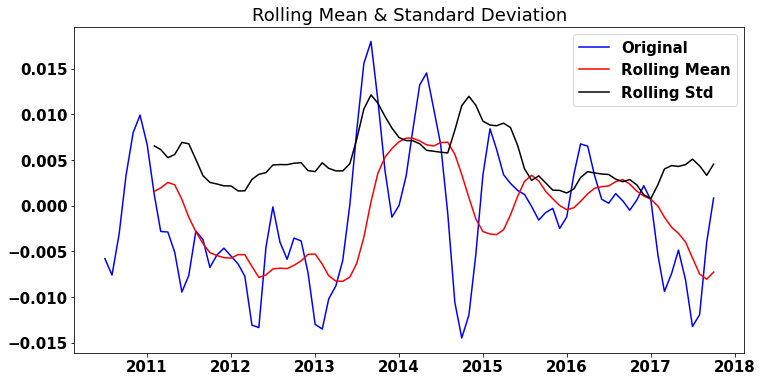

Results of Dickey-Fuller Test: 

Test Statistic                 -2.758424
p-value                         0.064462
#Lags Used                      4.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [33]:
stationarity_check(sd_90025)

Without differencing, the residuals in our log transformed time series data are not stationary.


# SARIMA Modeling

Lets fit a new SARIMAX model to our data. I'll begin by finding the best parameters to use for our model. To do this, I'll be using a grid search to find the optimal parameters for the model.

In [34]:
## generate all different combinations for p, q, and d. Using a range of 6 because the differencing periods required
## to make our data stationary for zipcode 90025 was 5

p = d = q = range(0, 6)
pdq = list(itertools.product(p, d, q))

In [35]:
## define a function that iterates over all pdq values and returns the combination that has the lowest AIC score

def get_optimal_pdq(df, pdq):
    results = []
    for comb in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=comb,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            results.append([comb, output.aic])
            # print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue
    
    return sorted(results, key=lambda x: x[-1])[0][0]

In [36]:
get_optimal_pdq(np.log(zip_90272), pdq)

(1, 1, 3)

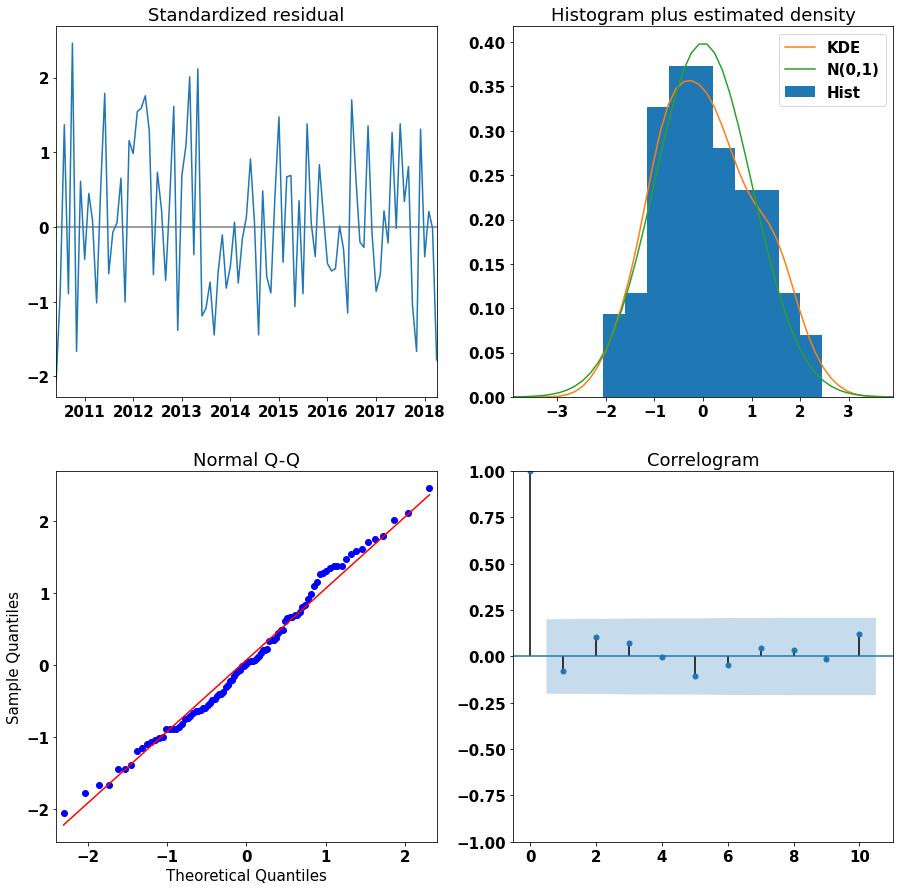

In [89]:
model_90272 = sm.tsa.statespace.SARIMAX(np.log(zip_90272),
                                        order=(1, 1, 3),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
output = model_90272.fit()
output.plot_diagnostics(figsize=(15, 15))
plt.show()

In the graph on the top left, there doesn't seem to be any seasonality in our data. Looking at the histogram and qq plots, we can see that our data follows the trend of the standard normal distribution showing a good indication that the residuals are normally distributed. These observations show that our model has no correlations and provides a satisfactory fit to forecast future values. 

## Forecast for 90272

In [90]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_conf = pred.conf_int()

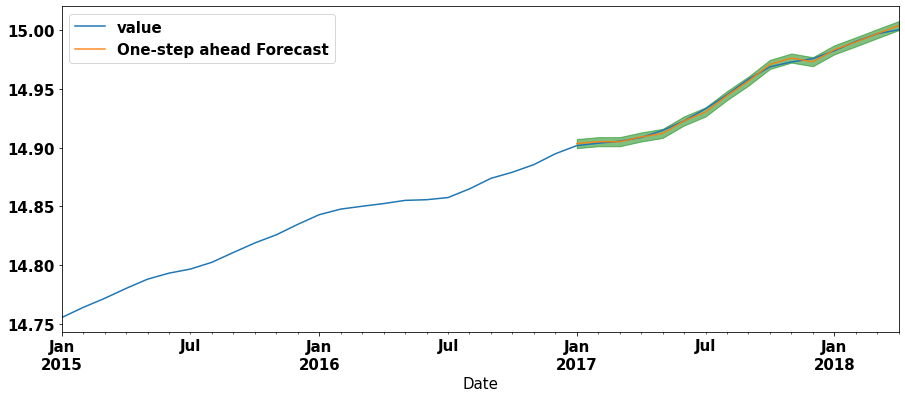

In [91]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = np.log(zip_90272)['2015':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
plt.legend()

plt.show()

In [100]:
forecast = pred.predicted_mean
real = np.log(zip_90272)['2017-01-01':]['value']

print(f'The MSE of our forecast is {round(mean_squared_error(real, forecast), 2)}')

The MSE of our forecast is 0.0


In [93]:
prediction = output.get_forecast(steps=48)
pred_conf = prediction.conf_int()

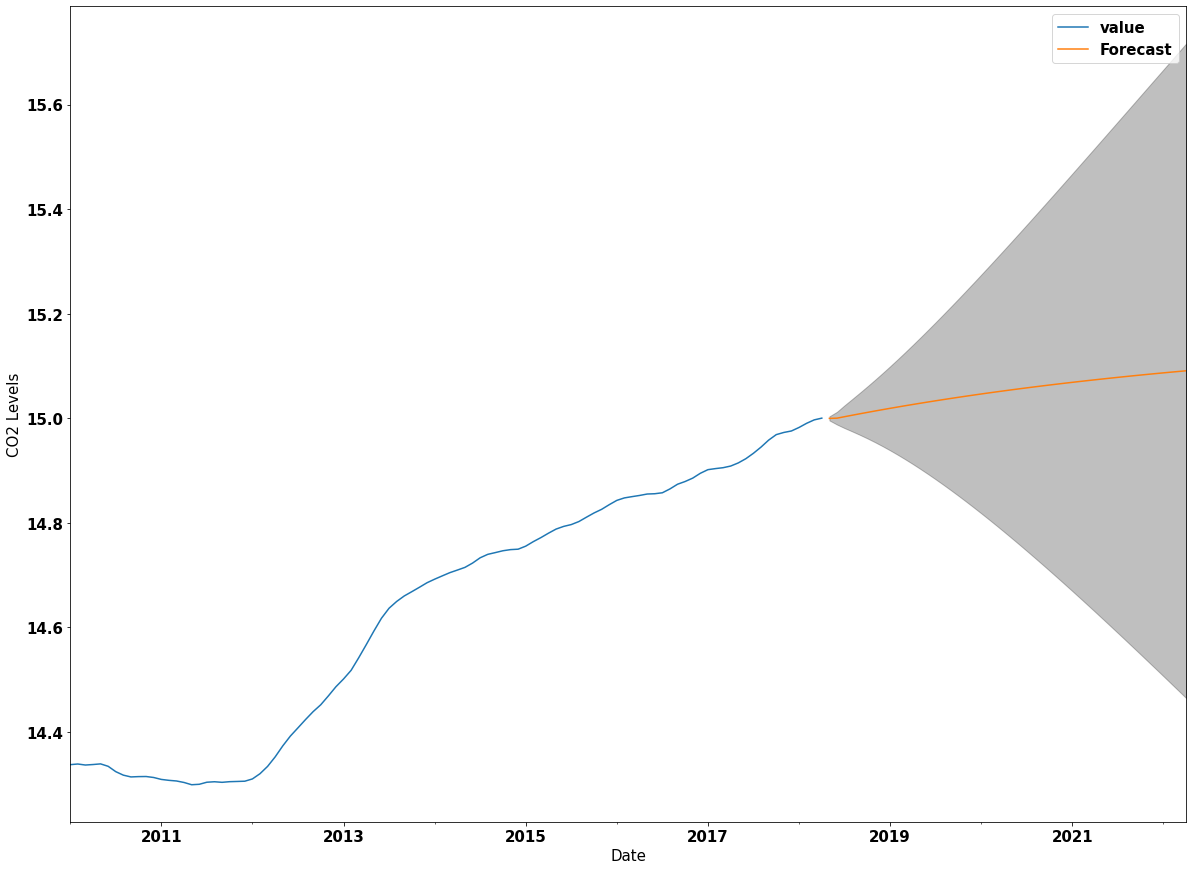

In [94]:
# Plot future predictions with confidence intervals
ax = np.log(zip_90272).plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [95]:
## figuring out ROI 4 years out using time series forecasting

current = zip_90272['value'][-1]
forecast = np.exp(prediction.predicted_mean[-1])
yhat_lower = np.exp(pred_conf['lower value'][-1])
yhat_upper = np.exp(pred_conf['upper value'][-1])

ROI = (forecast - current)/current
print(f'Current Value: ${current}')
print(f'Value in 4 years: ${forecast}')
print(f'Minimum Return on Investment: {round(((yhat_lower - current)/current) * 100, 2)}%')
print(f'Expected Return on Investment: {round(ROI * 100, 2)}%')
print(f'Maximum Return on Investment: {round(((yhat_upper - current)/current) * 100, 2)}%')

Current Value: $3269800.0
Value in 4 years: $3579847.8348389473
Minimum Return on Investment: -41.46%
Expected Return on Investment: 9.48%
Maximum Return on Investment: 104.77%


Using a 4 year forecast with our SARIMA model, an investment in a home in zipcode 90272 will return 9.48% in 4 years.

## SARIMA 90025

Now let's run SARIMA modeling on the 90025 zip code.

In [44]:
get_optimal_pdq(np.log(zip_90025), pdq)

(2, 1, 3)

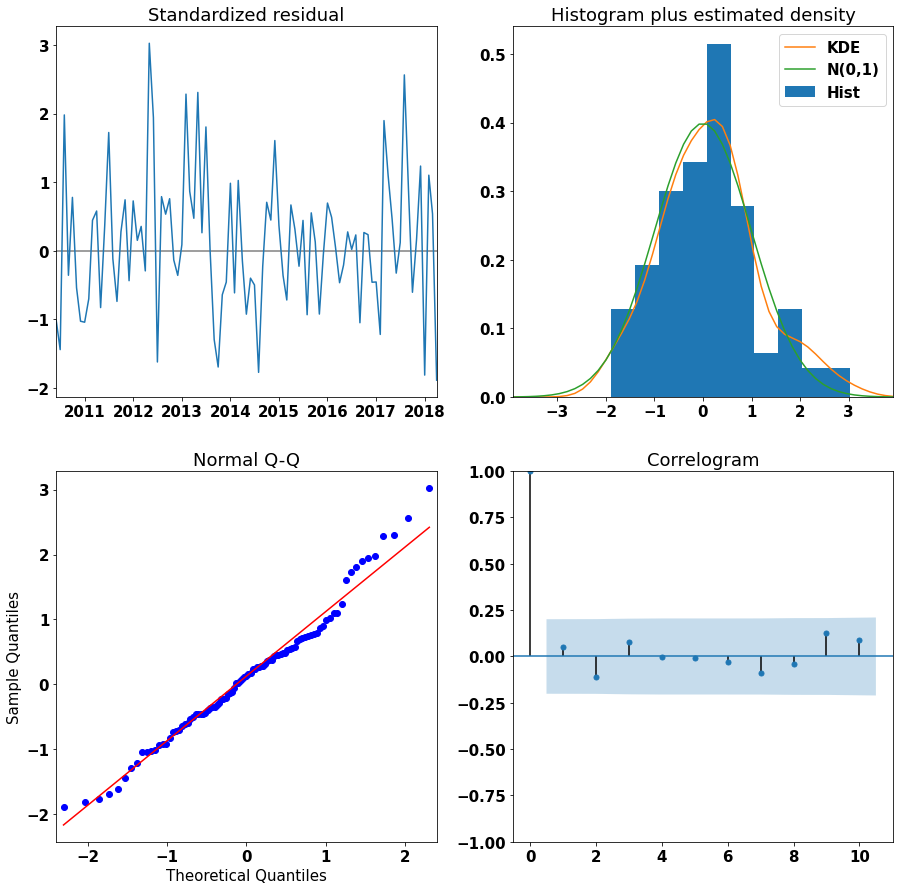

In [45]:
model_90025 = sm.tsa.statespace.SARIMAX(np.log(zip_90025),
                                        order=(2, 1, 3),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
output = model_90025.fit()
output.plot_diagnostics(figsize=(15, 15))
plt.show()

The residuals from 90025 also remain uncorrelated and relatively normally distributed. Now let's forecast future values.

## Forecast for 90025

In [46]:
pred = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_conf = pred.conf_int()

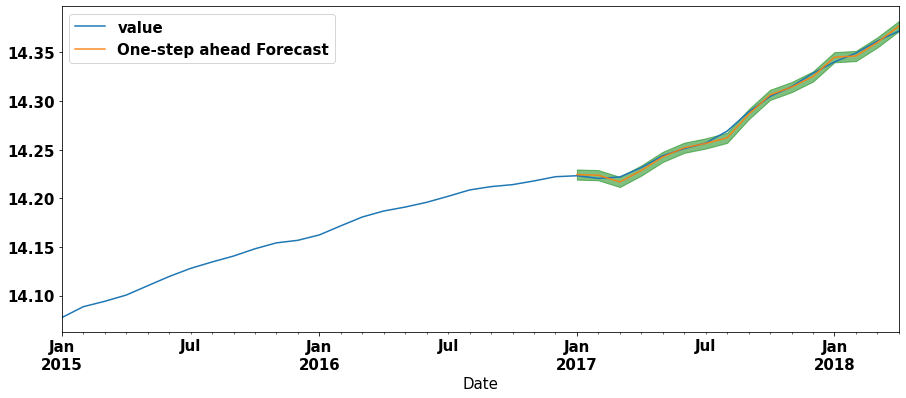

In [47]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = np.log(zip_90025)['2015':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
plt.legend()

plt.show()

In [48]:
forecast = pred.predicted_mean
real = np.log(zip_90025)['2017-01-01':]['value']

print(f'The MSE of our forecast is {round(mean_squared_error(real, forecast), 2)}')

The MSE of our forecast is 0.0


In [49]:
prediction = output.get_forecast(steps=48)
pred_conf = prediction.conf_int()

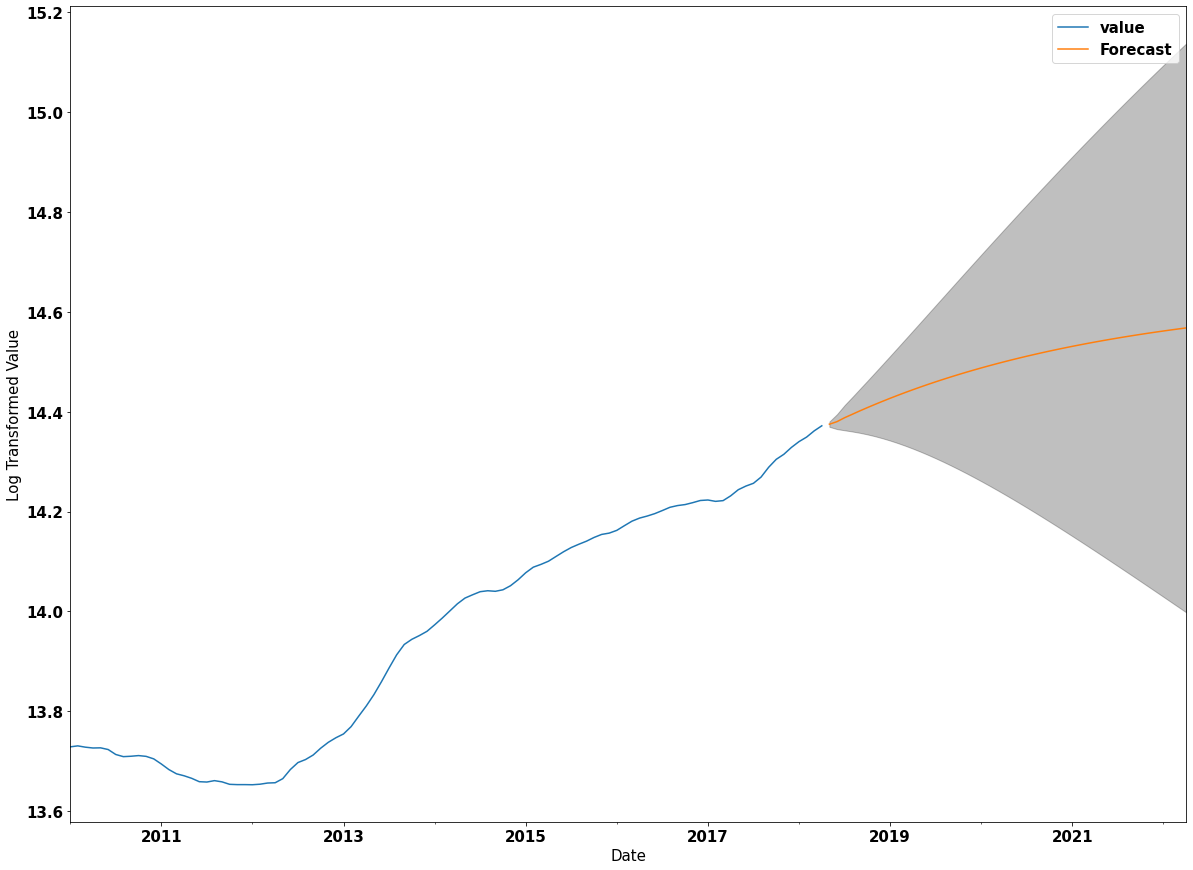

In [50]:
# Plot future predictions with confidence intervals
ax = np.log(zip_90025).plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Log Transformed Value')

plt.legend()
plt.show()

In [88]:
## figuring out ROI 4 years out using time series forecasting

current = zip_90025['value'][-1]
forecast = np.exp(prediction.predicted_mean[-1])
yhat_lower = np.exp(pred_conf['lower value'][-1])
yhat_upper = np.exp(pred_conf['upper value'][-1])

ROI = (forecast - current)/current
print(f'Current Value: ${current}')
print(f'Value in 4 years: ${forecast}')
print(f'Minimum Return on Investment: {round(((yhat_lower - current)/current) * 100, 2)}%')
print(f'Expected Return on Investment: {round(ROI * 100, 2)}%')
print(f'Maximum Return on Investment: {round(((yhat_upper - current)/current) * 100, 2)}%')

Current Value: $1744100.0
Value in 4 years: $2122011.598541929
Minimum Return on Investment: -31.18%
Expected Return on Investment: 21.67%
Maximum Return on Investment: 115.11%


Based on a 4 year forecast with our model, an investment in a home in zipcode 90025 will have a 21.67% return on investment in 4 years.

# Forecast for Top 20 LA Zipcodes

After running models and finding ROI for two zipcodes, I'll be making a function to iterate over the top 20 zipcodes in LA and find the zipcodes with the best ROI in 4 years.

In [102]:
def return_on_investment(df):
    zipcodes_roi_info = []
    
    for zipcode in df['RegionName'].unique():
        zip_df = df[df['RegionName'] == zipcode].drop('RegionName', axis=1).set_index('time')
        
        current_zip = str(zipcode)
        
        optimal_pdq = get_optimal_pdq(np.log(zip_df), pdq)
        
        model = sm.tsa.statespace.SARIMAX(np.log(zip_df),
                                          order=optimal_pdq,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        output = model.fit()
        
        prediction = output.get_forecast(steps=48)
        pred_conf = prediction.conf_int()
        
        ##plotting future predictions with confidence intervals
        ax = np.log(zip_df).plot(label='observed', figsize=(14, 7))
        prediction.predicted_mean.plot(ax=ax, label='Forecast')
        ax.fill_between(pred_conf.index,
                        pred_conf.iloc[:, 0],
                        pred_conf.iloc[:, 1], color='k', alpha=0.25)
        ax.set_xlabel('Year')
        ax.set_ylabel('Log Transformed Value')
        ax.set_title(f'Forecast for {current_zip}')

        plt.legend()
        plt.show()
        
        ## MSE
        pred = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
        pred_forecast = pred.predicted_mean
        real = np.log(zip_df)['2017-01-01':]['value']
        
        print(f'Optimal PDQ: {optimal_pdq}')
        print(f'MSE for {current_zip} is: {round(mean_squared_error(real, pred_forecast), 4)}')
        
        ## figuring out ROI 4 years out using time series forecasting
        current = zip_df['value'][-1]
        forecast = np.exp(prediction.predicted_mean[-1])
        yhat_lower = np.exp(pred_conf['lower value'][-1])
        yhat_upper = np.exp(pred_conf['upper value'][-1])

        ROI = (forecast - current)/current
        print(f'Current Value: ${current}')
        print(f'Value in 4 years: ${forecast}')
        print(f'Minimum Return on Investment: {round(((yhat_lower - current)/current) * 100, 2)}%')
        print(f'Expected Return on Investment: {round(ROI * 100, 2)}%')
        print(f'Maximum Return on Investment: {round(((yhat_upper - current)/current) * 100, 2)}%')
        
        zipcodes_roi_info.append({'Zipcode': current_zip, 
                                  'Current_Value': current, 
                                  'Future_Value': forecast, 
                                  'ROI': round(ROI * 100, 2),
                                  'Min_ROI': round(((yhat_lower - current)/current) * 100, 2),
                                  'Max_ROI': round(((yhat_upper - current)/current) * 100, 2)})
    
    return pd.DataFrame(zipcodes_roi_info)

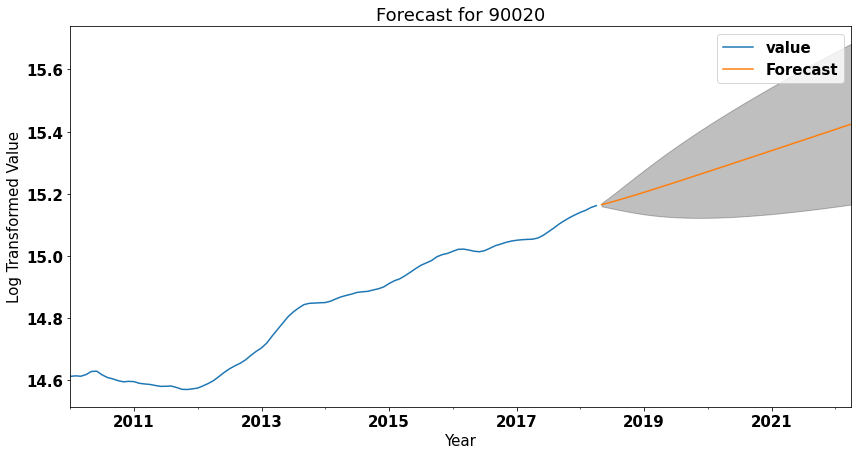

Optimal PDQ: (2, 0, 2)
MSE for 90020 is: 0.0
Current Value: $3842700.0
Value in 4 years: $4997053.496227731
Minimum Return on Investment: 0.37%
Expected Return on Investment: 30.04%
Maximum Return on Investment: 68.48%


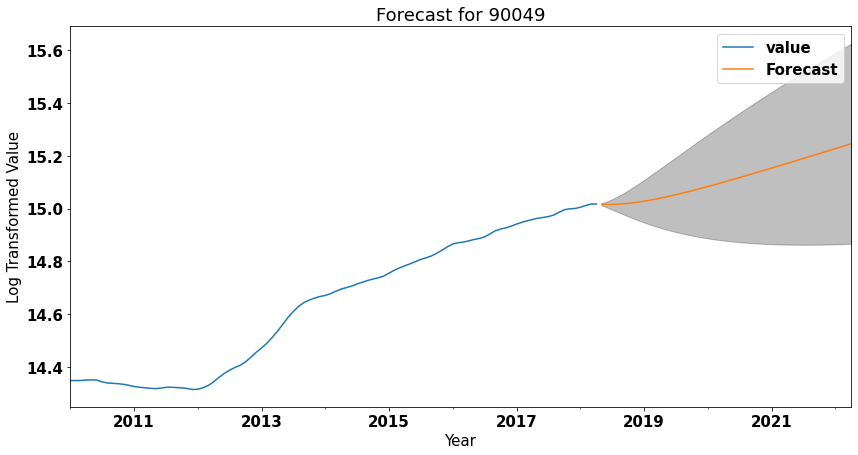

Optimal PDQ: (2, 0, 1)
MSE for 90049 is: 0.0
Current Value: $3326400.0
Value in 4 years: $4180013.450618089
Minimum Return on Investment: -14.02%
Expected Return on Investment: 25.66%
Maximum Return on Investment: 83.66%


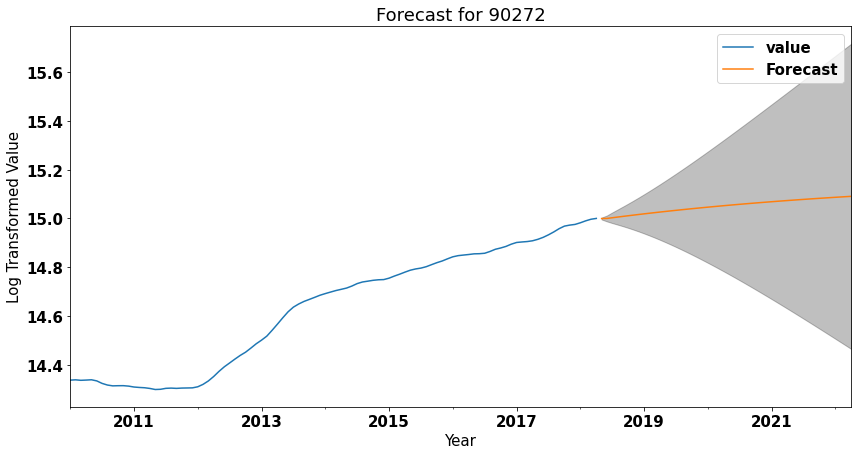

Optimal PDQ: (1, 1, 3)
MSE for 90272 is: 0.0
Current Value: $3269800.0
Value in 4 years: $3579847.8348389473
Minimum Return on Investment: -41.46%
Expected Return on Investment: 9.48%
Maximum Return on Investment: 104.77%


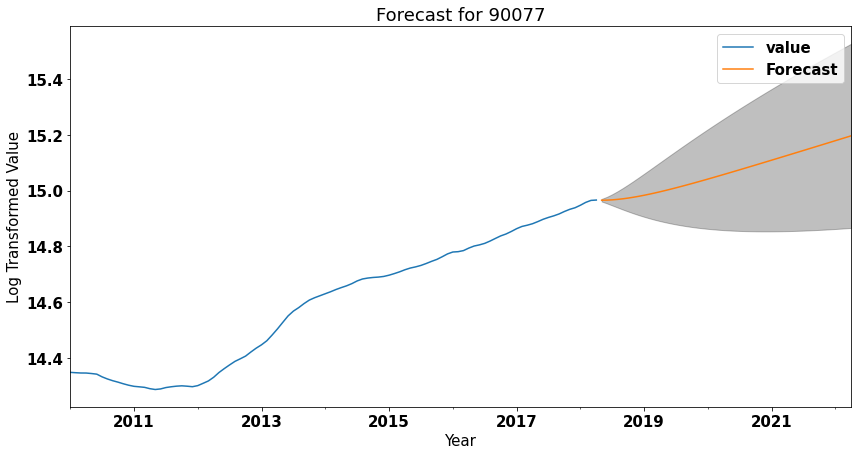

Optimal PDQ: (2, 0, 1)
MSE for 90077 is: 0.0
Current Value: $3159700.0
Value in 4 years: $3980338.239094662
Minimum Return on Investment: -9.52%
Expected Return on Investment: 25.97%
Maximum Return on Investment: 75.38%


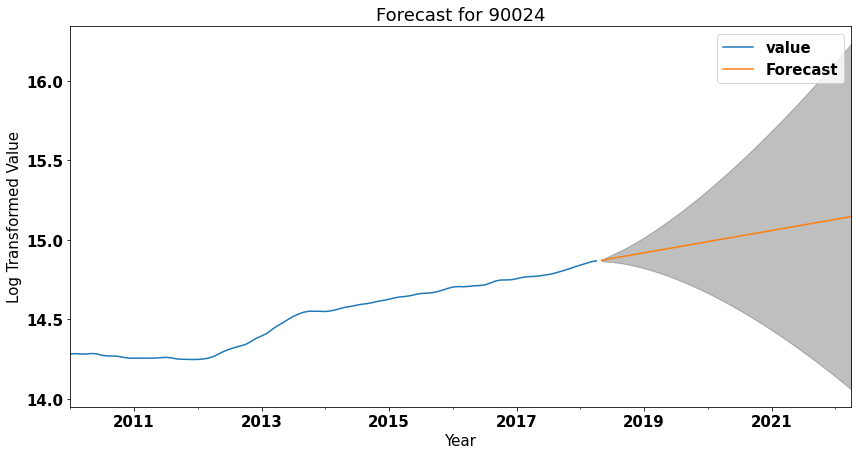

Optimal PDQ: (2, 2, 1)
MSE for 90024 is: 0.0
Current Value: $2864100.0
Value in 4 years: $3786834.785396712
Minimum Return on Investment: -55.48%
Expected Return on Investment: 32.22%
Maximum Return on Investment: 292.64%


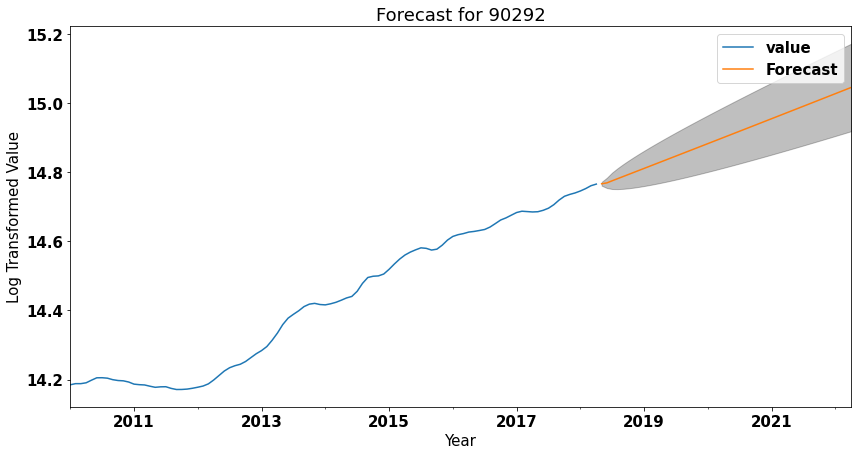

Optimal PDQ: (1, 0, 3)
MSE for 90292 is: 0.0
Current Value: $2586500.0
Value in 4 years: $3422607.7520033265
Minimum Return on Investment: 16.57%
Expected Return on Investment: 32.33%
Maximum Return on Investment: 50.2%


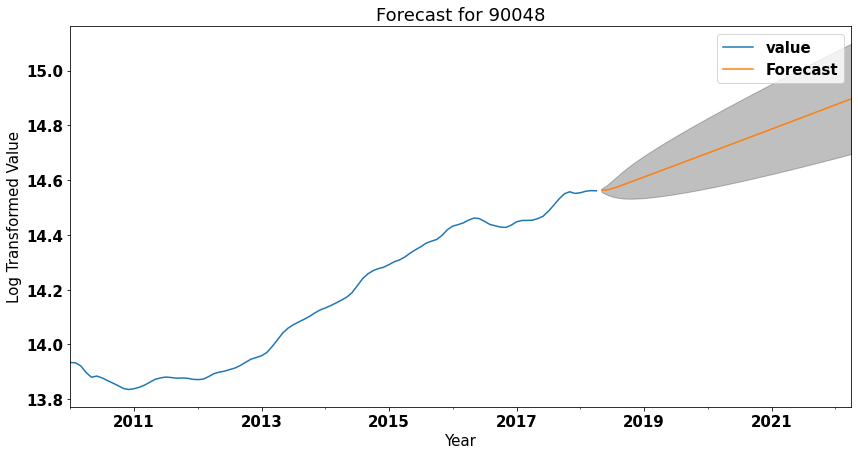

Optimal PDQ: (1, 0, 4)
MSE for 90048 is: 0.0
Current Value: $2107500.0
Value in 4 years: $2948587.6364498
Minimum Return on Investment: 14.37%
Expected Return on Investment: 39.91%
Maximum Return on Investment: 71.15%


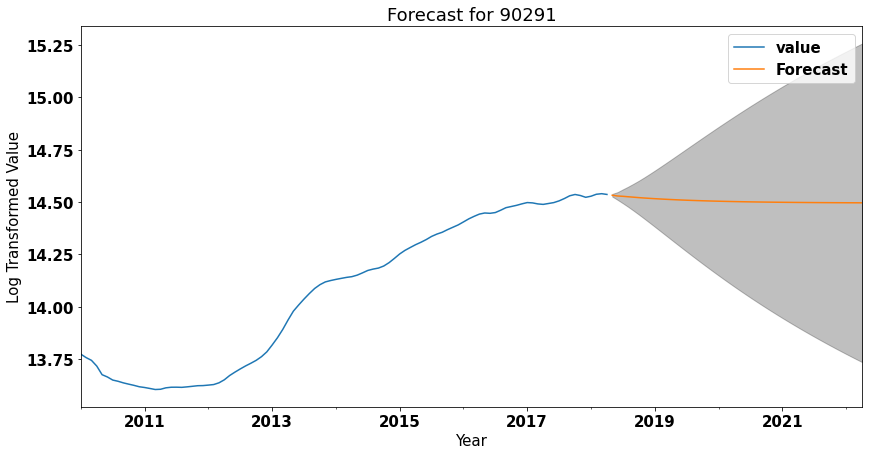

Optimal PDQ: (5, 1, 4)
MSE for 90291 is: 0.0
Current Value: $2056800.0
Value in 4 years: $1976170.6460555752
Minimum Return on Investment: -55.09%
Expected Return on Investment: -3.92%
Maximum Return on Investment: 105.53%


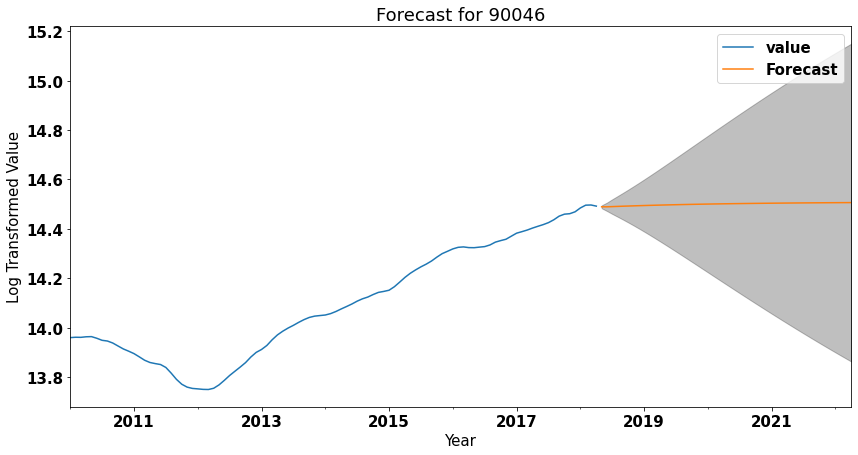

Optimal PDQ: (1, 1, 3)
MSE for 90046 is: 0.0
Current Value: $1966900.0
Value in 4 years: $1995210.500636506
Minimum Return on Investment: -46.7%
Expected Return on Investment: 1.44%
Maximum Return on Investment: 93.06%


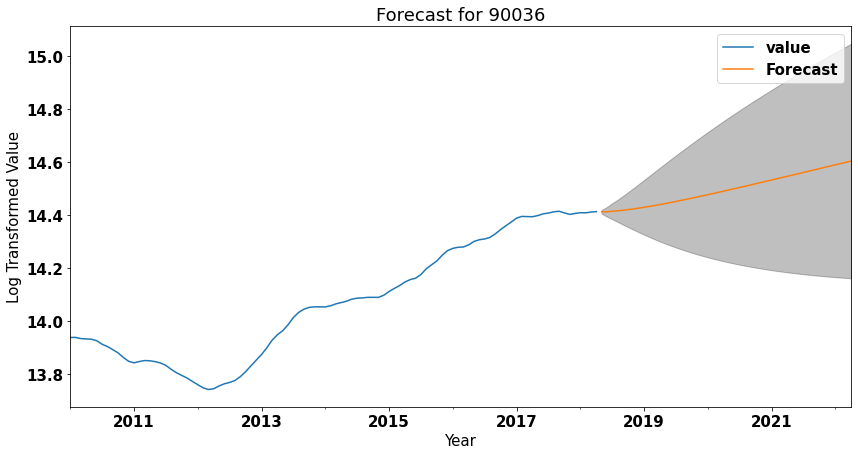

Optimal PDQ: (4, 0, 3)
MSE for 90036 is: 0.0
Current Value: $1820000.0
Value in 4 years: $2203827.2360906648
Minimum Return on Investment: -22.25%
Expected Return on Investment: 21.09%
Maximum Return on Investment: 88.59%


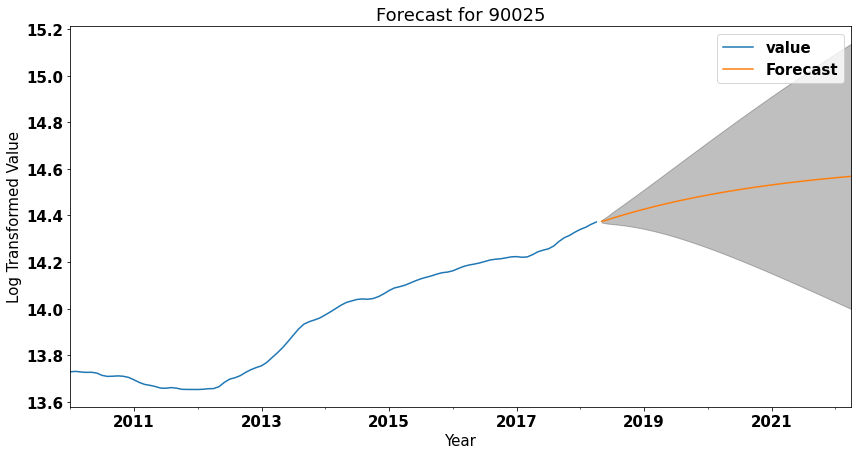

Optimal PDQ: (2, 1, 3)
MSE for 90025 is: 0.0
Current Value: $1744100.0
Value in 4 years: $2122011.598541929
Minimum Return on Investment: -31.18%
Expected Return on Investment: 21.67%
Maximum Return on Investment: 115.11%


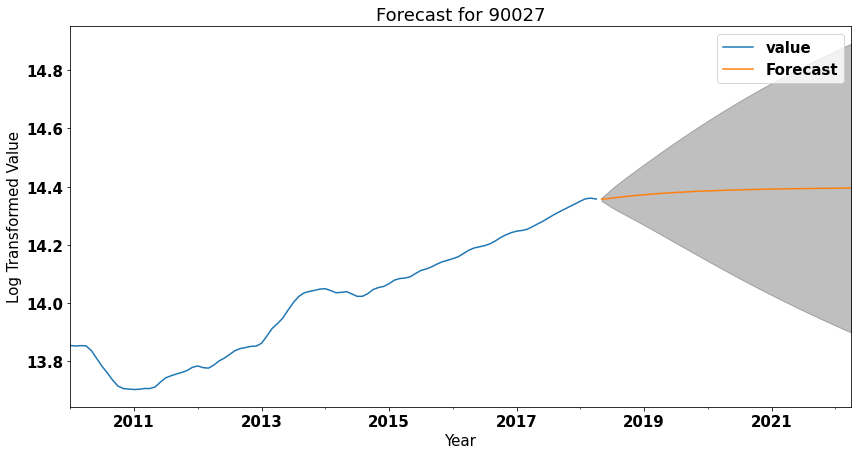

Optimal PDQ: (1, 1, 3)
MSE for 90027 is: 0.0
Current Value: $1719400.0
Value in 4 years: $1785182.869354483
Minimum Return on Investment: -36.78%
Expected Return on Investment: 3.83%
Maximum Return on Investment: 70.51%


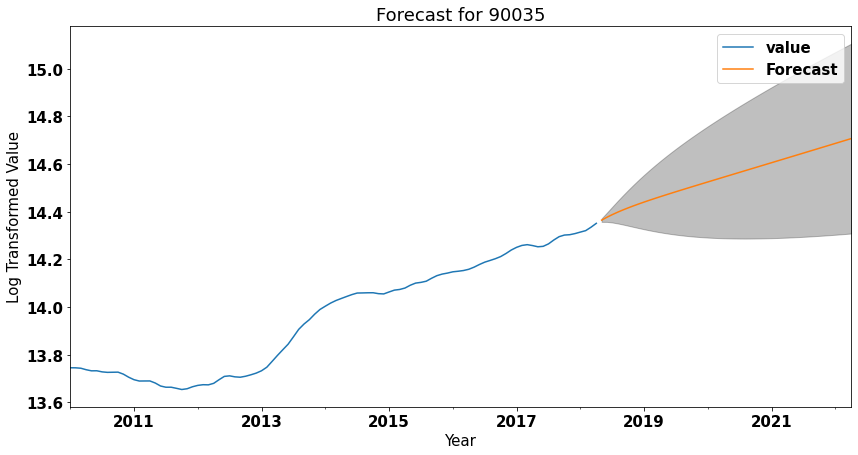

Optimal PDQ: (2, 0, 1)
MSE for 90035 is: 0.0
Current Value: $1709000.0
Value in 4 years: $2439828.189608507
Minimum Return on Investment: -4.17%
Expected Return on Investment: 42.76%
Maximum Return on Investment: 112.68%


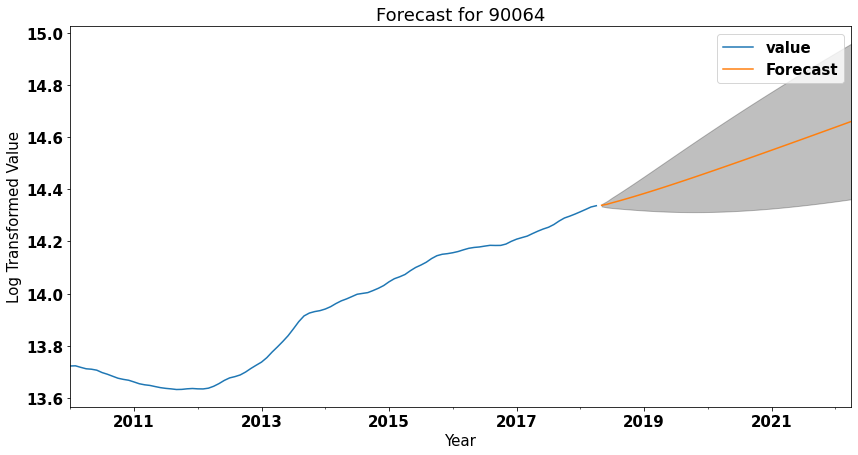

Optimal PDQ: (3, 0, 3)
MSE for 90064 is: 0.0
Current Value: $1685000.0
Value in 4 years: $2328923.788757353
Minimum Return on Investment: 2.52%
Expected Return on Investment: 38.22%
Maximum Return on Investment: 86.33%


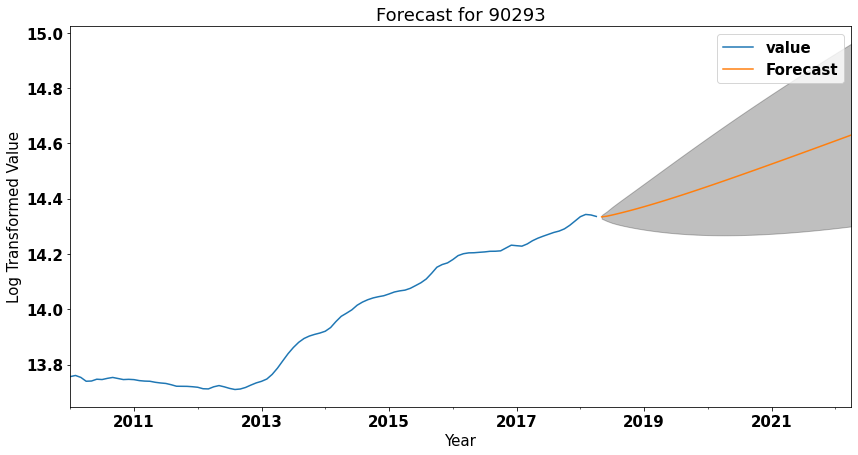

Optimal PDQ: (2, 0, 3)
MSE for 90293 is: 0.0
Current Value: $1681800.0
Value in 4 years: $2257819.8923297604
Minimum Return on Investment: -3.53%
Expected Return on Investment: 34.25%
Maximum Return on Investment: 86.82%


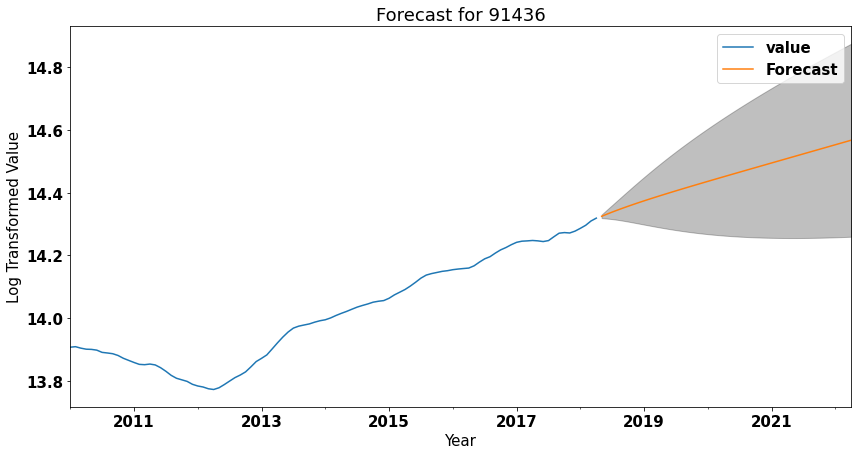

Optimal PDQ: (2, 0, 2)
MSE for 91436 is: 0.0
Current Value: $1654200.0
Value in 4 years: $2120379.145365657
Minimum Return on Investment: -5.75%
Expected Return on Investment: 28.18%
Maximum Return on Investment: 74.32%


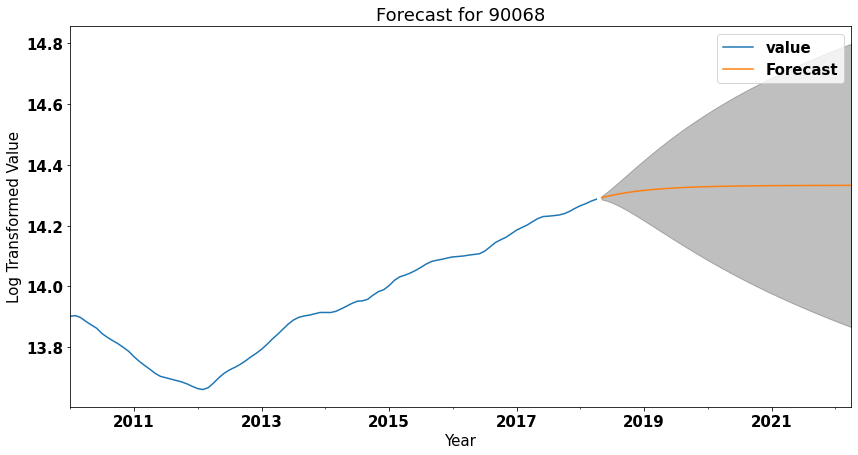

Optimal PDQ: (1, 1, 1)
MSE for 90068 is: 0.0
Current Value: $1602200.0
Value in 4 years: $1676911.2618634277
Minimum Return on Investment: -34.39%
Expected Return on Investment: 4.66%
Maximum Return on Investment: 66.95%


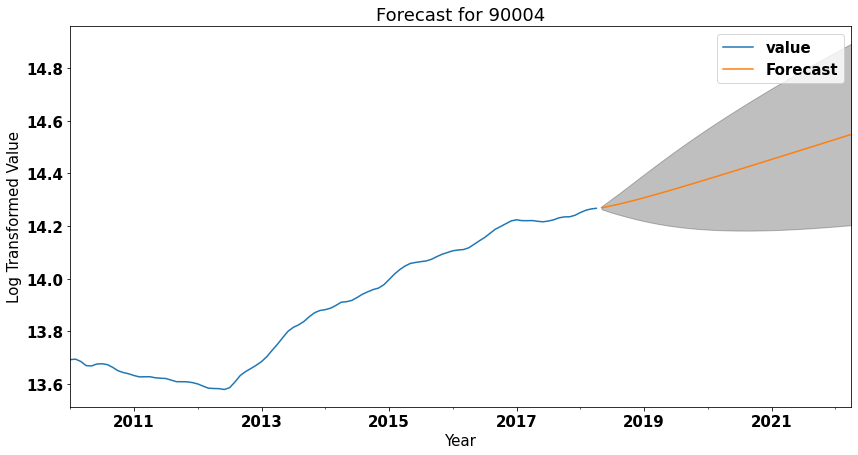

Optimal PDQ: (3, 0, 5)
MSE for 90004 is: 0.0
Current Value: $1571600.0
Value in 4 years: $2081553.9735228964
Minimum Return on Investment: -6.2%
Expected Return on Investment: 32.45%
Maximum Return on Investment: 87.02%


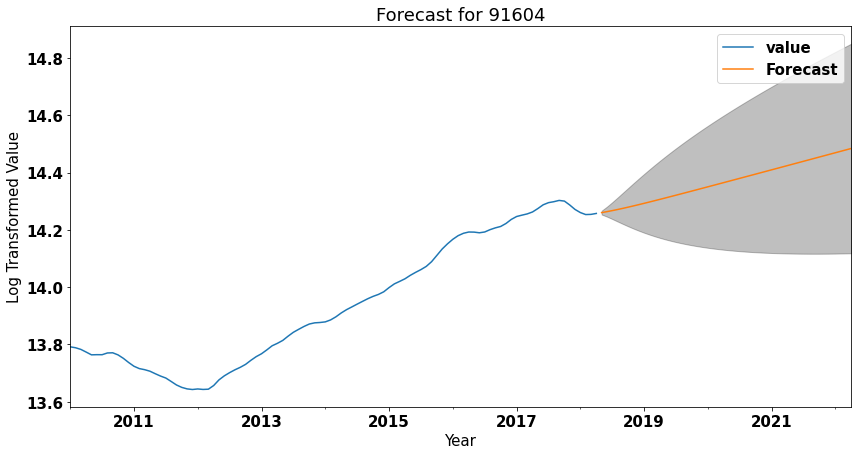

Optimal PDQ: (2, 0, 1)
MSE for 91604 is: 0.0
Current Value: $1555300.0
Value in 4 years: $1951315.5702563946
Minimum Return on Investment: -12.97%
Expected Return on Investment: 25.46%
Maximum Return on Investment: 80.87%


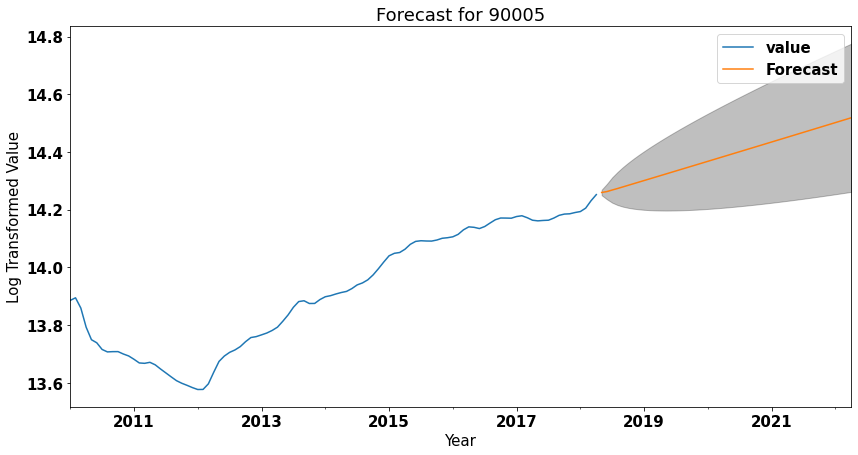

Optimal PDQ: (1, 0, 4)
MSE for 90005 is: 0.0
Current Value: $1547100.0
Value in 4 years: $2019792.7327577963
Minimum Return on Investment: 0.96%
Expected Return on Investment: 30.55%
Maximum Return on Investment: 68.82%


In [103]:
roi_df = return_on_investment(LA)

In [106]:
roi_df.sort_values('ROI', ascending=False)

Zipcode  Current_Value  Future_Value    ROI  Min_ROI  Max_ROI
12   90035      1709000.0  2.439828e+06  42.76    -4.17   112.68
6    90048      2107500.0  2.948588e+06  39.91    14.37    71.15
13   90064      1685000.0  2.328924e+06  38.22     2.52    86.33
14   90293      1681800.0  2.257820e+06  34.25    -3.53    86.82
17   90004      1571600.0  2.081554e+06  32.45    -6.20    87.02
5    90292      2586500.0  3.422608e+06  32.33    16.57    50.20
4    90024      2864100.0  3.786835e+06  32.22   -55.48   292.64
19   90005      1547100.0  2.019793e+06  30.55     0.96    68.82
0    90020      3842700.0  4.997053e+06  30.04     0.37    68.48
15   91436      1654200.0  2.120379e+06  28.18    -5.75    74.32
3    90077      3159700.0  3.980338e+06  25.97    -9.52    75.38
1    90049      3326400.0  4.180013e+06  25.66   -14.02    83.66
18   91604      1555300.0  1.951316e+06  25.46   -12.97    80.87
10   90025      1744100.0  2.122012e+06  21.67   -31.18   115.11
9    90036      1820000.0  2.203827e+06  21.09   -22.25    88.59
2    90272      3269800.0  3.579848e+06   9.48   -41.46   104.77
16   90068      1602200.0  1.676911e+06   4.66   -34.39    66.95
11   90027      1719400.0  1.785183e+06   3.83   -36.78    70.51
8    90046      1966900.0  1.995211e+06   1.44   -46.70    93.06
7    90291      2056800.0  1.976171e+06  -3.92   -55.09   105.53

In [107]:
roi_df.sort_values('Min_ROI', ascending=False)

Zipcode  Current_Value  Future_Value    ROI  Min_ROI  Max_ROI
5    90292      2586500.0  3.422608e+06  32.33    16.57    50.20
6    90048      2107500.0  2.948588e+06  39.91    14.37    71.15
13   90064      1685000.0  2.328924e+06  38.22     2.52    86.33
19   90005      1547100.0  2.019793e+06  30.55     0.96    68.82
0    90020      3842700.0  4.997053e+06  30.04     0.37    68.48
14   90293      1681800.0  2.257820e+06  34.25    -3.53    86.82
12   90035      1709000.0  2.439828e+06  42.76    -4.17   112.68
15   91436      1654200.0  2.120379e+06  28.18    -5.75    74.32
17   90004      1571600.0  2.081554e+06  32.45    -6.20    87.02
3    90077      3159700.0  3.980338e+06  25.97    -9.52    75.38
18   91604      1555300.0  1.951316e+06  25.46   -12.97    80.87
1    90049      3326400.0  4.180013e+06  25.66   -14.02    83.66
9    90036      1820000.0  2.203827e+06  21.09   -22.25    88.59
10   90025      1744100.0  2.122012e+06  21.67   -31.18   115.11
16   90068      1602200.0  1.676911e+06   4.66   -34.39    66.95
11   90027      1719400.0  1.785183e+06   3.83   -36.78    70.51
2    90272      3269800.0  3.579848e+06   9.48   -41.46   104.77
8    90046      1966900.0  1.995211e+06   1.44   -46.70    93.06
7    90291      2056800.0  1.976171e+06  -3.92   -55.09   105.53
4    90024      2864100.0  3.786835e+06  32.22   -55.48   292.64

After running the top 20 zipcodes through SARIMA modeling, the top 5 zipcodes with the highest ROI are 90035, 90048, 90064, 90293, and 90004. Most of the zipcodes in Los Angeles will have a pretty decent ROI, with most of them having a ROI of 20% or more. The top 5 ROI by zipcodes eclipse 32% with the highest ROI being 43%. 

If the investor is worried about the potential error in the predictions I would suggest investing in zipcodes that have high minimum return on investment. By doing this, you can invest in the zipcodes with the least variance as predicted by the model. The zipcodes with the highest minimum return on investment are 90292, 90048, 90064, 90005, and 90020. The expected ROI for these zipcodes are all above 30%.

Next I'll run the data through Facebooks Prophet for time series to see if both models predict the same results.

# FB Prophet

In order to use fbprophet we'll need to make some changes to our data before we can run it through fbprophet. We'll need to change the time column name to "ds" and the value column name to "y".

In [55]:
fb_90272 = zip_90272.reset_index()
fb_90272.rename(columns={'time': 'ds', 'value': 'y'}, inplace=True)
fb_90272.head()

ds          y
0 2010-01-01  1685200.0
1 2010-02-01  1687300.0
2 2010-03-01  1684000.0
3 2010-04-01  1685600.0
4 2010-05-01  1687700.0

In [56]:
Model = Prophet(interval_width=0.95)
Model.fit(fb_90272)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
future_dates = Model.make_future_dataframe(periods=48, freq='MS')
future_dates.tail()

ds
143 2021-12-01
144 2022-01-01
145 2022-02-01
146 2022-03-01
147 2022-04-01

In [58]:
forecast = Model.predict(future_dates)
forecast

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0   2010-01-01  1.698704e+06  1.677281e+06  1.714540e+06  1.698704e+06   
1   2010-02-01  1.693000e+06  1.667319e+06  1.705181e+06  1.693000e+06   
2   2010-03-01  1.687847e+06  1.664222e+06  1.702035e+06  1.687847e+06   
3   2010-04-01  1.682142e+06  1.656697e+06  1.695456e+06  1.682142e+06   
4   2010-05-01  1.676621e+06  1.654030e+06  1.690408e+06  1.676621e+06   
..         ...           ...           ...           ...           ...   
143 2021-12-01  4.208276e+06  3.148008e+06  5.203234e+06  3.143762e+06   
144 2022-01-01  4.229934e+06  3.147332e+06  5.261815e+06  3.145826e+06   
145 2022-02-01  4.251592e+06  3.135614e+06  5.315243e+06  3.143271e+06   
146 2022-03-01  4.271154e+06  3.112781e+06  5.358594e+06  3.120334e+06   
147 2022-04-01  4.292813e+06  3.084507e+06  5.423568e+06  3.076850e+06   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    1.698704e+06    -3155.126679          -3155.126679          -3155.126679   
1    1.693000e+06    -5614.463887          -5614.463887          -5614.463887   
2    1.687847e+06    -5353.520831          -5353.520831          -5353.520831   
3    1.682142e+06    -6022.179223          -6022.179223          -6022.179223   
4    1.676621e+06    -4082.706795          -4082.706795          -4082.706795   
..            ...             ...                   ...                   ...   
143  5.195980e+06     1513.632157           1513.632157           1513.632157   
144  5.273033e+06    -3155.126679          -3155.126679          -3155.126679   
145  5.325788e+06    -5614.463887          -5614.463887          -5614.463887   
146  5.374893e+06    -5353.520831          -5353.520831          -5353.520831   
147  5.436256e+06    -6022.179223          -6022.179223          -6022.179223   

          yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0   -3155.126679  -3155.126679  -3155.126679                   0.0   
1   -5614.463887  -5614.463887  -5614.463887                   0.0   
2   -5353.520831  -5353.520831  -5353.520831                   0.0   
3   -6022.179223  -6022.179223  -6022.179223                   0.0   
4   -4082.706795  -4082.706795  -4082.706795                   0.0   
..           ...           ...           ...                   ...   
143  1513.632157   1513.632157   1513.632157                   0.0   
144 -3155.126679  -3155.126679  -3155.126679                   0.0   
145 -5614.463887  -5614.463887  -5614.463887                   0.0   
146 -5353.520831  -5353.520831  -5353.520831                   0.0   
147 -6022.179223  -6022.179223  -6022.179223                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                           0.0                         0.0  1.695549e+06  
1                           0.0                         0.0  1.687385e+06  
2                           0.0                         0.0  1.682493e+06  
3                           0.0                         0.0  1.676120e+06  
4                           0.0                         0.0  1.672538e+06  
..                          ...                         ...           ...  
143                         0.0                         0.0  4.209789e+06  
144                         0.0                         0.0  4.226779e+06  
145                         0.0                         0.0  4.245978e+06  
146                         0.0                         0.0  4.265801e+06  
147                         0.0                         0.0  4.286790e+06  

[148 rows x 16 columns]

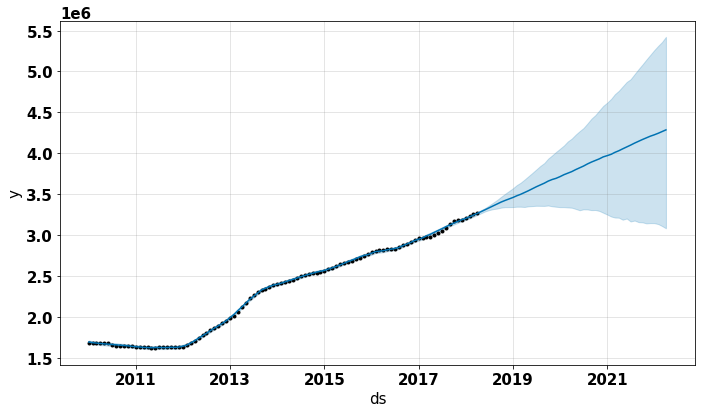

In [59]:
Model.plot(forecast, uncertainty=True)
plt.show()

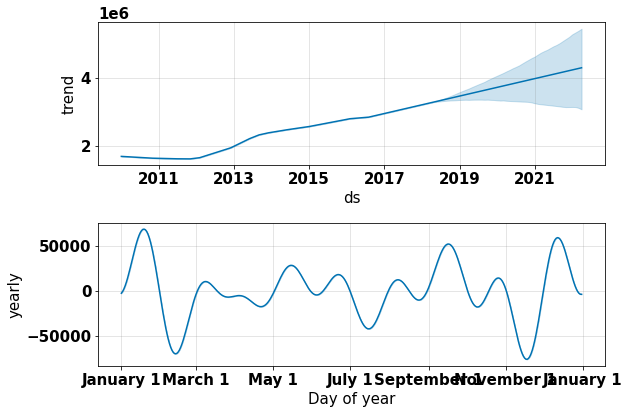

In [60]:
Model.plot_components(forecast)
plt.show()

In [116]:
fb_90025 = zip_90025.reset_index()
fb_90025.rename(columns={'time': 'ds', 'value': 'y'}, inplace=True)
fb_90025.head()

ds         y
0 2010-01-01  916700.0
1 2010-02-01  918500.0
2 2010-03-01  916100.0
3 2010-04-01  914600.0
4 2010-05-01  914900.0

In [117]:
Model = Prophet(interval_width=0.95)
Model.fit(fb_90025)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [118]:
future_dates = Model.make_future_dataframe(periods=36, freq='MS')
forecast = Model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
131 2020-12-01  2.088467e+06  1.869810e+06  2.310825e+06
132 2021-01-01  2.095692e+06  1.873669e+06  2.321668e+06
133 2021-02-01  2.103909e+06  1.861748e+06  2.329636e+06
134 2021-03-01  2.122183e+06  1.875707e+06  2.365238e+06
135 2021-04-01  2.133965e+06  1.871589e+06  2.382693e+06

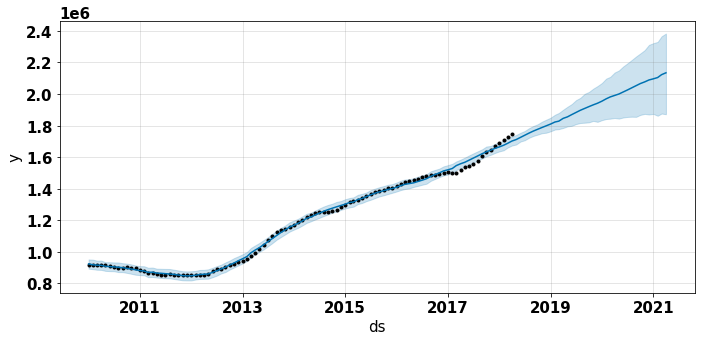

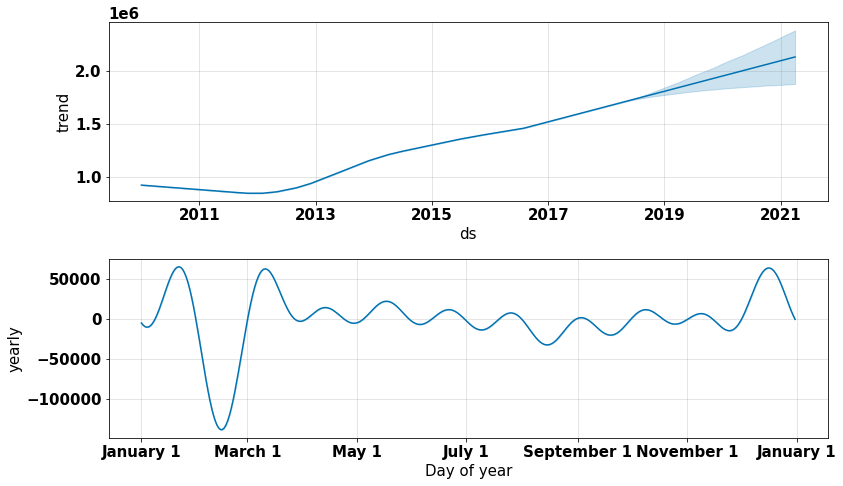

In [171]:
Model.plot(forecast, uncertainty=True, figsize=(10, 5))
Model.plot_components(forecast, figsize=(12, 7))
plt.show()

In [172]:
def fbprophet_forecast(df):
    zipcodes_forecast = []
    
    for zipcode in df['RegionName'].unique():
        zip_df = df[df['RegionName'] == zipcode].drop('RegionName', axis=1)
        zip_df.rename(columns={'time': 'ds', 'value': 'y'}, inplace=True)
        
        current_zip = str(zipcode)
        
        Model = Prophet(interval_width=0.95)
        Model.fit(zip_df)
    
        future_dates = Model.make_future_dataframe(periods=48, freq='MS')
        forecast = Model.predict(future_dates)
        
        Model.plot(forecast, uncertainty=True, figsize=(10, 5))
        plt.title(f'Forecast for {current_zip}')
        plt.xlabel('Year')
        plt.ylabel('Value')
        plt.show()
        
        
        ## figuring out ROI 4 years out using time series forecasting
        max_idx = zip_df['y'].idxmax()
        max_idx_forecast = forecast['yhat'].idxmax()
        
        current = zip_df['y'][max_idx]
        forecast_value = forecast['yhat'][max_idx_forecast]
        yhat_lower = forecast['yhat_lower'][max_idx_forecast]
        yhat_upper = forecast['yhat_upper'][max_idx_forecast]
        ROI = (forecast_value - current)/current
        
        print(f'Current Value: ${current}')
        print(f'Value in 4 years: ${forecast_value}')
        print(f'Minimum Return on Investment: {round(((yhat_lower - current)/current) * 100, 2)}%')
        print(f'Expected Return on Investment: {round(ROI * 100, 2)}%')
        print(f'Maximum Return on Investment: {round(((yhat_upper - current)/current) * 100, 2)}%')
        
        zipcodes_forecast.append({'Zipcode': current_zip, 
                                  'Current_Value': current, 
                                  'Future_Value': forecast_value, 
                                  'ROI': round(ROI * 100, 2),
                                  'Min_ROI': round(((yhat_lower - current)/current) * 100, 2),
                                  'Max_ROI': round(((yhat_upper - current)/current) * 100, 2)})
        
    return pd.DataFrame(zipcodes_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


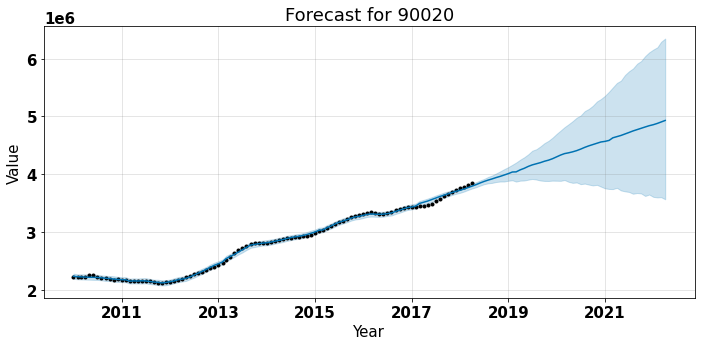

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $3842700.0
Value in 4 years: $4931157.251760082
Minimum Return on Investment: -7.14%
Expected Return on Investment: 28.33%
Maximum Return on Investment: 65.16%


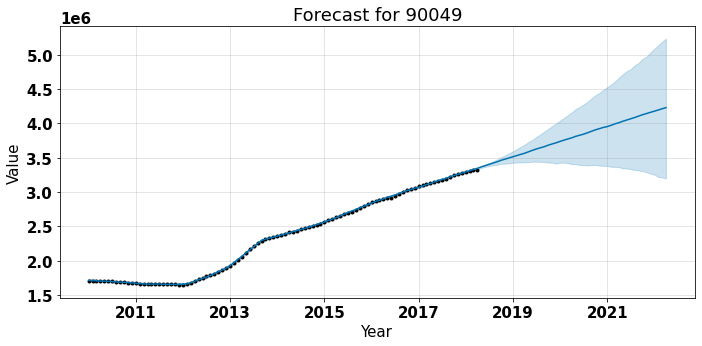

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $3326400.0
Value in 4 years: $4228675.902409396
Minimum Return on Investment: -3.88%
Expected Return on Investment: 27.12%
Maximum Return on Investment: 57.41%


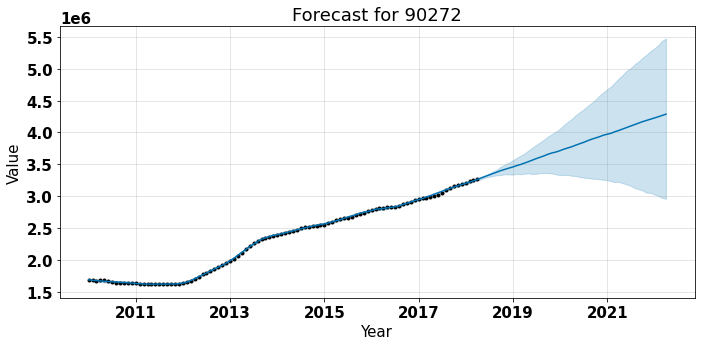

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $3269800.0
Value in 4 years: $4286790.365127351
Minimum Return on Investment: -9.38%
Expected Return on Investment: 31.1%
Maximum Return on Investment: 67.28%


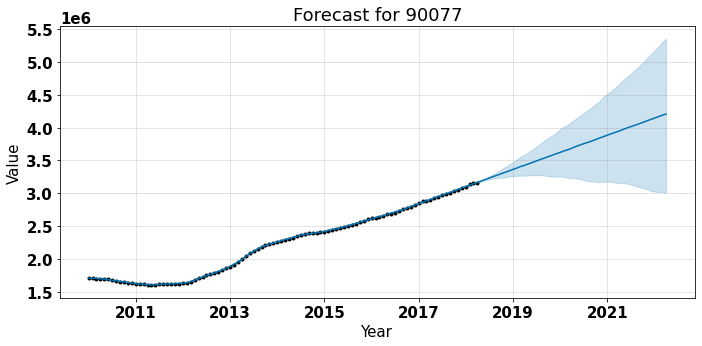

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $3159700.0
Value in 4 years: $4207672.199270941
Minimum Return on Investment: -4.9%
Expected Return on Investment: 33.17%
Maximum Return on Investment: 69.64%


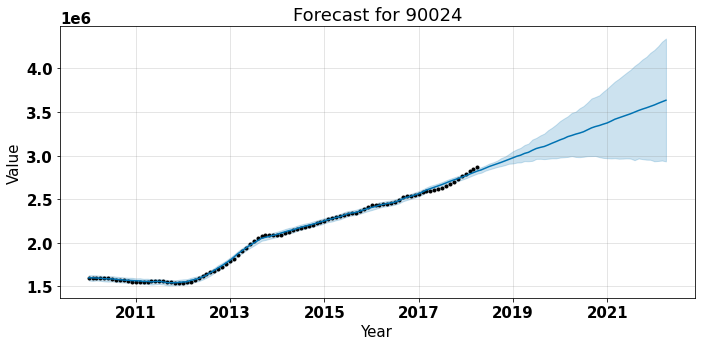

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $2864100.0
Value in 4 years: $3635196.1160349273
Minimum Return on Investment: 2.42%
Expected Return on Investment: 26.92%
Maximum Return on Investment: 51.66%


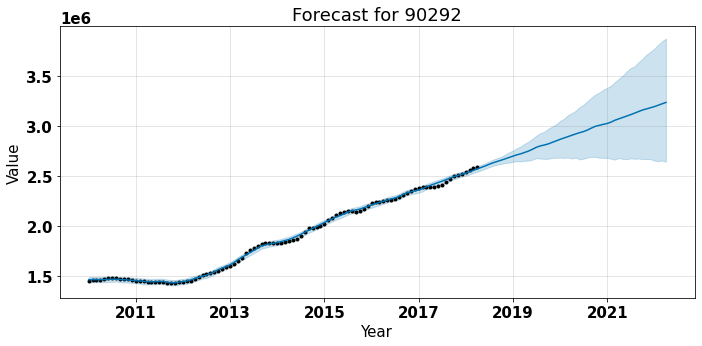

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $2586500.0
Value in 4 years: $3233918.9115314856
Minimum Return on Investment: 2.08%
Expected Return on Investment: 25.03%
Maximum Return on Investment: 49.75%


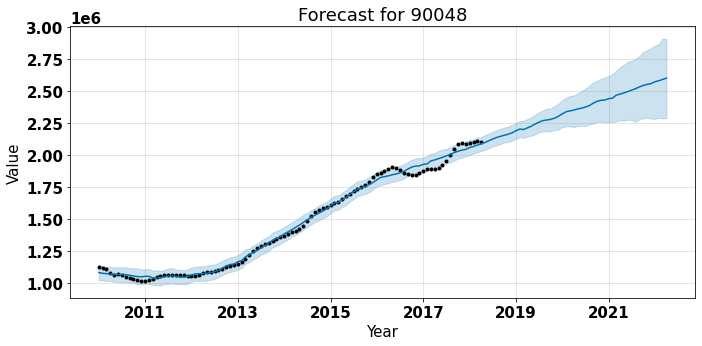

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $2108600.0
Value in 4 years: $2602766.6200985485
Minimum Return on Investment: 8.69%
Expected Return on Investment: 23.44%
Maximum Return on Investment: 37.88%


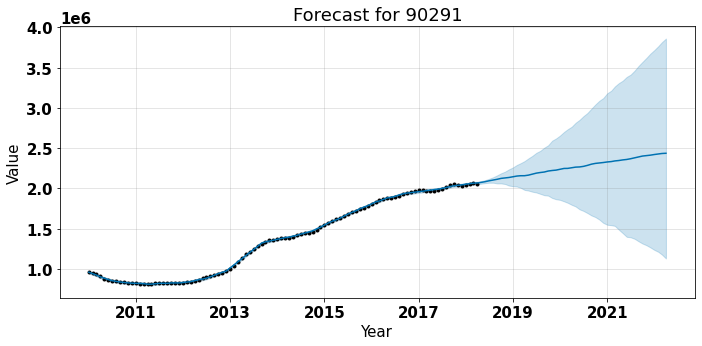

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $2064200.0
Value in 4 years: $2436022.149645707
Minimum Return on Investment: -45.34%
Expected Return on Investment: 18.01%
Maximum Return on Investment: 87.1%


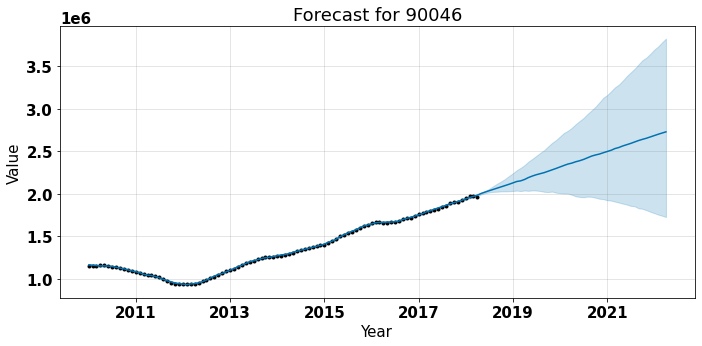

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $1975900.0
Value in 4 years: $2729346.283515872
Minimum Return on Investment: -12.57%
Expected Return on Investment: 38.13%
Maximum Return on Investment: 93.68%


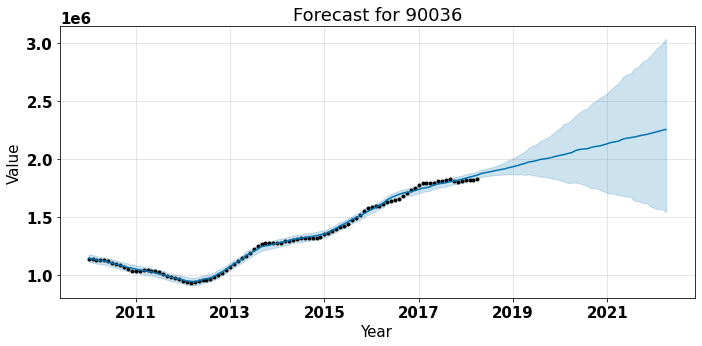

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $1823000.0
Value in 4 years: $2252261.02469049
Minimum Return on Investment: -15.58%
Expected Return on Investment: 23.55%
Maximum Return on Investment: 66.53%


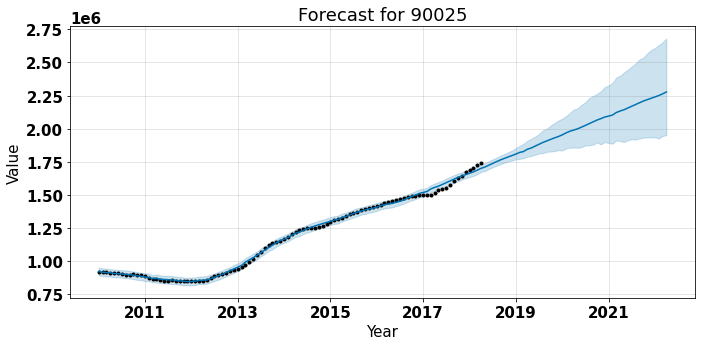

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $1744100.0
Value in 4 years: $2277741.101605142
Minimum Return on Investment: 11.96%
Expected Return on Investment: 30.6%
Maximum Return on Investment: 53.7%


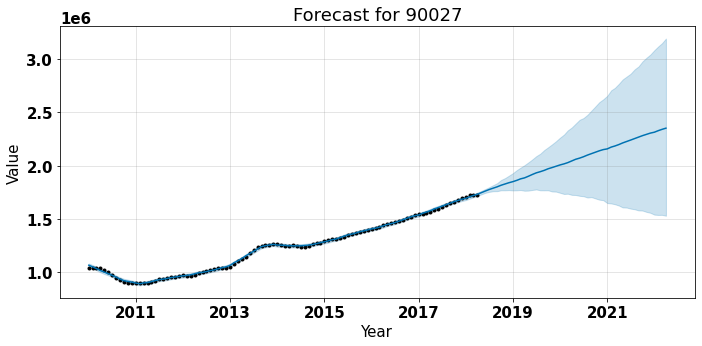

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $1724300.0
Value in 4 years: $2351569.4841957237
Minimum Return on Investment: -11.38%
Expected Return on Investment: 36.38%
Maximum Return on Investment: 85.25%


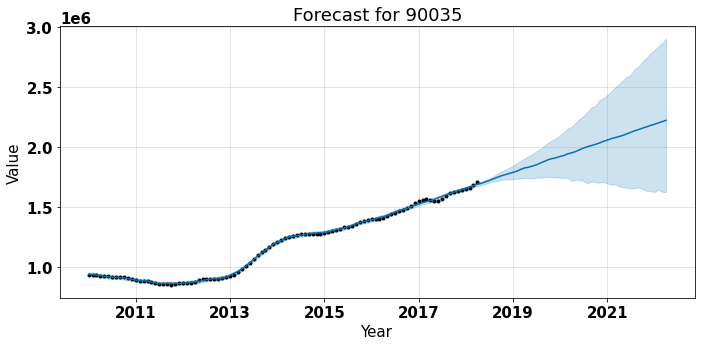

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $1709000.0
Value in 4 years: $2221022.799708105
Minimum Return on Investment: -5.06%
Expected Return on Investment: 29.96%
Maximum Return on Investment: 69.85%


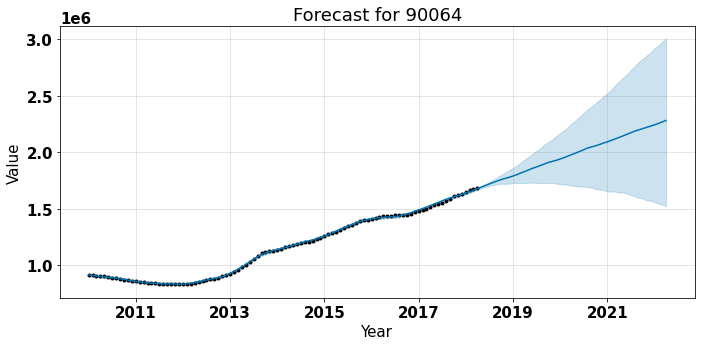

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $1685000.0
Value in 4 years: $2279050.929233025
Minimum Return on Investment: -9.49%
Expected Return on Investment: 35.26%
Maximum Return on Investment: 78.28%


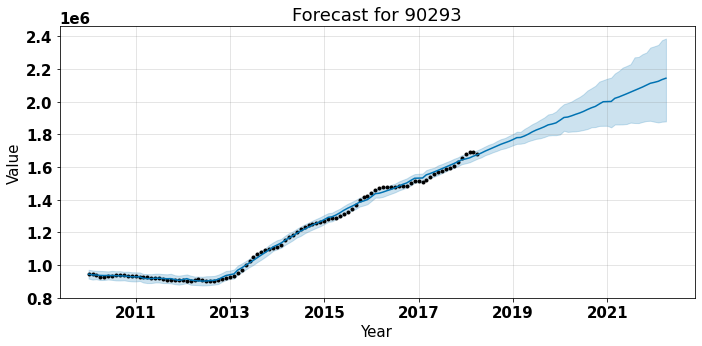

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $1694000.0
Value in 4 years: $2142927.623664138
Minimum Return on Investment: 10.9%
Expected Return on Investment: 26.5%
Maximum Return on Investment: 40.83%


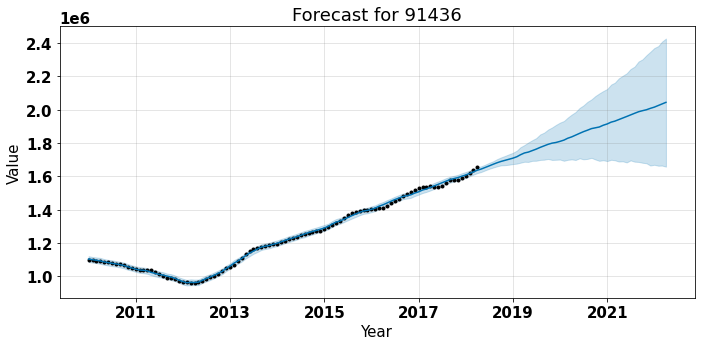

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $1654200.0
Value in 4 years: $2043035.4656986545
Minimum Return on Investment: 0.22%
Expected Return on Investment: 23.51%
Maximum Return on Investment: 46.62%


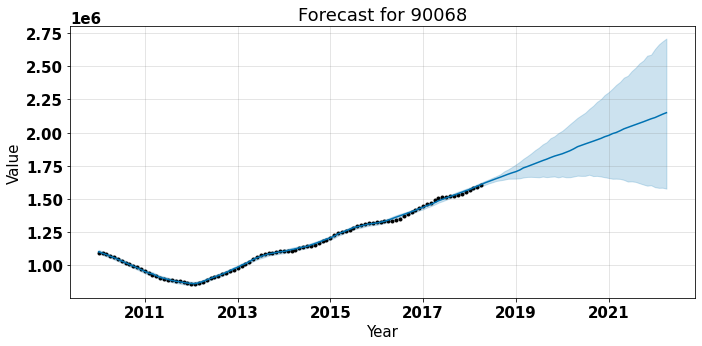

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $1602200.0
Value in 4 years: $2149946.631606188
Minimum Return on Investment: -1.58%
Expected Return on Investment: 34.19%
Maximum Return on Investment: 69.11%


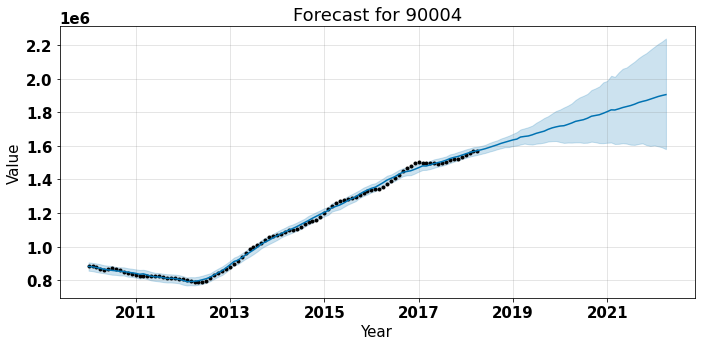

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $1571600.0
Value in 4 years: $1904526.0657577203
Minimum Return on Investment: 0.54%
Expected Return on Investment: 21.18%
Maximum Return on Investment: 42.4%


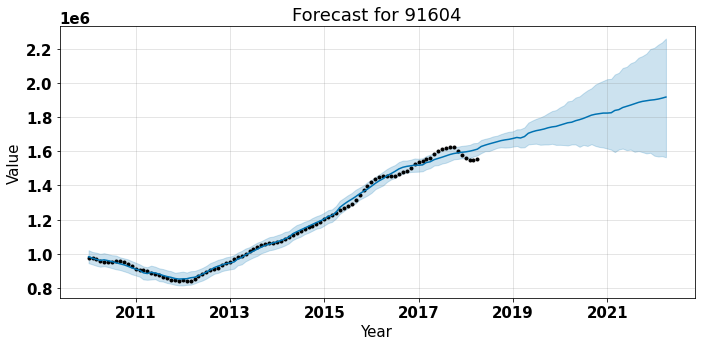

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Current Value: $1627600.0
Value in 4 years: $1918556.3573986893
Minimum Return on Investment: -3.82%
Expected Return on Investment: 17.88%
Maximum Return on Investment: 38.96%


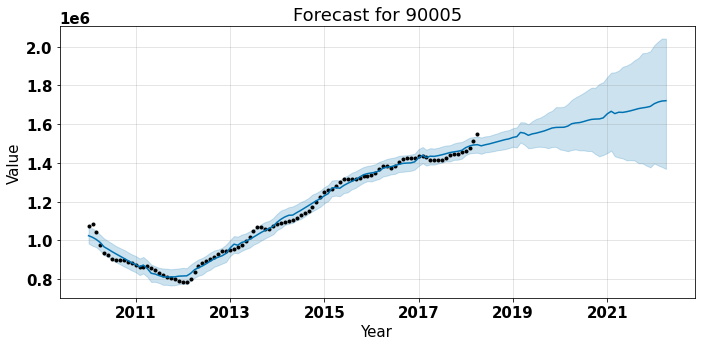

Current Value: $1547100.0
Value in 4 years: $1720831.5896224924
Minimum Return on Investment: -11.54%
Expected Return on Investment: 11.23%
Maximum Return on Investment: 31.94%


In [173]:
fb_roi_df = fbprophet_forecast(LA)

In [177]:
fb_roi_df.sort_values('ROI', ascending=False)

Zipcode  Current_Value  Future_Value    ROI  Min_ROI  Max_ROI
8    90046      1975900.0  2.729346e+06  38.13   -12.57    93.68
11   90027      1724300.0  2.351569e+06  36.38   -11.38    85.25
13   90064      1685000.0  2.279051e+06  35.26    -9.49    78.28
16   90068      1602200.0  2.149947e+06  34.19    -1.58    69.11
3    90077      3159700.0  4.207672e+06  33.17    -4.90    69.64
2    90272      3269800.0  4.286790e+06  31.10    -9.38    67.28
10   90025      1744100.0  2.277741e+06  30.60    11.96    53.70
12   90035      1709000.0  2.221023e+06  29.96    -5.06    69.85
0    90020      3842700.0  4.931157e+06  28.33    -7.14    65.16
1    90049      3326400.0  4.228676e+06  27.12    -3.88    57.41
4    90024      2864100.0  3.635196e+06  26.92     2.42    51.66
14   90293      1694000.0  2.142928e+06  26.50    10.90    40.83
5    90292      2586500.0  3.233919e+06  25.03     2.08    49.75
9    90036      1823000.0  2.252261e+06  23.55   -15.58    66.53
15   91436      1654200.0  2.043035e+06  23.51     0.22    46.62
6    90048      2108600.0  2.602767e+06  23.44     8.69    37.88
17   90004      1571600.0  1.904526e+06  21.18     0.54    42.40
7    90291      2064200.0  2.436022e+06  18.01   -45.34    87.10
18   91604      1627600.0  1.918556e+06  17.88    -3.82    38.96
19   90005      1547100.0  1.720832e+06  11.23   -11.54    31.94

In [179]:
fb_roi_df.sort_values('Min_ROI', ascending=False)

Zipcode  Current_Value  Future_Value    ROI  Min_ROI  Max_ROI
10   90025      1744100.0  2.277741e+06  30.60    11.96    53.70
14   90293      1694000.0  2.142928e+06  26.50    10.90    40.83
6    90048      2108600.0  2.602767e+06  23.44     8.69    37.88
4    90024      2864100.0  3.635196e+06  26.92     2.42    51.66
5    90292      2586500.0  3.233919e+06  25.03     2.08    49.75
17   90004      1571600.0  1.904526e+06  21.18     0.54    42.40
15   91436      1654200.0  2.043035e+06  23.51     0.22    46.62
16   90068      1602200.0  2.149947e+06  34.19    -1.58    69.11
18   91604      1627600.0  1.918556e+06  17.88    -3.82    38.96
1    90049      3326400.0  4.228676e+06  27.12    -3.88    57.41
3    90077      3159700.0  4.207672e+06  33.17    -4.90    69.64
12   90035      1709000.0  2.221023e+06  29.96    -5.06    69.85
0    90020      3842700.0  4.931157e+06  28.33    -7.14    65.16
2    90272      3269800.0  4.286790e+06  31.10    -9.38    67.28
13   90064      1685000.0  2.279051e+06  35.26    -9.49    78.28
11   90027      1724300.0  2.351569e+06  36.38   -11.38    85.25
19   90005      1547100.0  1.720832e+06  11.23   -11.54    31.94
8    90046      1975900.0  2.729346e+06  38.13   -12.57    93.68
9    90036      1823000.0  2.252261e+06  23.55   -15.58    66.53
7    90291      2064200.0  2.436022e+06  18.01   -45.34    87.10

ROI = 90035, 90048, 90064, 90293, 90004

Min ROI = 90292, 90048, 90064, 90005, 90020

FB ROI = 90046, 90027, 90064, 90068, 90077

FB Min ROI = 90025, 90293, 90048, 90024, 90292

# Step 6: Interpreting Results